In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector
import tensorflow as tf
import os
from keras.layers import TimeDistributed
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
"""
New Data
"""
#data = pd.read_csv("curvy_data.csv")
data = pd.read_csv("traj_data_v2.csv")
data.describe()

,Unnamed: 0,Vehicle_ID,X,Y,X_REL,Y_REL
count,307834.00000,307834.000000,307834.000000,307834.000000,3.078340e+05,3.078340e+05
mean,153916.50000,153892.000884,151.187971,-33.894347,4.361413e-07,4.547582e-07
std,88864.16572,88864.166079,0.002386,0.001482,2.208221e-05,1.067770e-05
min,0.00000,0.000000,151.184833,-33.895620,-6.331820e-05,-4.471060e-05
25%,76958.25000,76950.000000,151.186520,-33.895157,-1.109110e-05,-5.980100e-06
50%,153916.50000,153900.000000,151.187506,-33.894778,0.000000e+00,0.000000e+00
75%,230874.75000,230850.000000,151.188627,-33.894293,1.225900e-05,7.062200e-06
max,307833.00000,307800.000000,151.194606,-33.888825,6.605090e-05,4.435870e-05


In [4]:
len(data['Vehicle_ID'].unique())

6157

In [65]:
len(data['Vehicle_ID'])

307834

In [5]:
"""
Preprocess data, removed torch tensors return type, now np arrays
"""
def preprocess_dataset(data, max = 10, max_len = 40, input_len = 30):
    scaler = MinMaxScaler(feature_range=(0, max))
    data[['X_REL', 'Y_REL']] = scaler.fit_transform(data[['X_REL', 'Y_REL']])
    global map_dict
    map_dict = {}
    unique_peds = data['Vehicle_ID'].unique()
    unique_peds = sorted(unique_peds)
    inputs = []
    indexes = []
    outputs = []
    seq = []
    for ped in unique_peds:
        if (len(data[data['Vehicle_ID'] == ped]) >= max_len):
          indexes.append(ped)
          seq_inner = []
          target_inner = 0
          i = 0
          for indx, row in data[data['Vehicle_ID'] == ped].iterrows():
            x = round(row['X_REL'])
            y = round(row['Y_REL'])
            ## Cantor pairing function:
            bin = y * max + x
            #print("X: ", x, " Y: ", y, " Bin: ", bin)
            map_dict[int(bin)] = [int(x), int(y)]
            i += 1
            if i == max_len:
              break
            seq_inner.append(int(bin))
          inputs.append([seq_inner[0:input_len]])
          outputs.append([seq_inner[input_len + 1:]])
    train_inputs, test_inputs, train_targets, test_targets, train_indx, test_indx = train_test_split(inputs, outputs, indexes, train_size=0.7, random_state=0)
    
    return np.array(train_inputs), np.array(test_inputs), np.array(train_targets), np.array(test_targets), train_indx, test_indx

In [12]:
train_data_inputs, test_data_inputs, train_data_targets, test_data_targets, train_indx, test_indx = preprocess_dataset(data, max = 100, max_len = 50, input_len = 20)

In [13]:
print(train_data_inputs.shape)
print(train_data_targets.shape)
train_data_inputs = train_data_inputs.reshape(train_data_inputs.shape[0], train_data_inputs.shape[2], 1)
train_data_targets = train_data_targets.reshape(train_data_targets.shape[0], train_data_targets.shape[2], 1)
print(train_data_inputs.shape)
print(train_data_targets.shape)

(4309, 1, 20)
(4309, 1, 28)
(4309, 20, 1)
(4309, 28, 1)


In [14]:
print(test_data_inputs.shape)
print(test_data_targets.shape)
test_data_inputs = test_data_inputs.reshape(test_data_inputs.shape[0], test_data_inputs.shape[2], 1)
test_data_targets = test_data_targets.reshape(test_data_targets.shape[0], test_data_targets.shape[2], 1)
print(test_data_inputs.shape)
print(test_data_targets.shape)

(1847, 1, 20)
(1847, 1, 28)
(1847, 20, 1)
(1847, 28, 1)


In [15]:
"""
def plot_prediction(test_index = 0, scaled = False):
  m = my_max
  i = inputs_scaled
  o = outputs_scaled
  if scaled == False:
    m = 1
    i = inputs
    o = outputs
  print(m)
  test_ind = test_index
  t = i[test_ind]
  t = t.reshape(1, 12, 2)
  b = model.predict(t)
  b = np.squeeze(b)
  xx = b[:,0] * m
  yy = b[:,1] * m
  check_tar = o[test_ind] * m
  check_input = i[test_ind] * m
  plt.plot(xx, yy, 'ro')
  plt.plot(check_tar[:,0], check_tar[:,1], 'bo')
  plt.plot(check_input[:,0], check_input[:,1])
"""

"\ndef plot_prediction(test_index = 0, scaled = False):\n  m = my_max\n  i = inputs_scaled\n  o = outputs_scaled\n  if scaled == False:\n    m = 1\n    i = inputs\n    o = outputs\n  print(m)\n  test_ind = test_index\n  t = i[test_ind]\n  t = t.reshape(1, 12, 2)\n  b = model.predict(t)\n  b = np.squeeze(b)\n  xx = b[:,0] * m\n  yy = b[:,1] * m\n  check_tar = o[test_ind] * m\n  check_input = i[test_ind] * m\n  plt.plot(xx, yy, 'ro')\n  plt.plot(check_tar[:,0], check_tar[:,1], 'bo')\n  plt.plot(check_input[:,0], check_input[:,1])\n"

In [10]:
def make_one_hot(inp):
  result = []
  for i in inp:
    inner = []
    for bin in i:
      one_hot_vector = np.zeros(((100*100) + 50), dtype= np.uint16)
      one_hot_vector[bin] = 1
      inner.append(one_hot_vector)
    result.append(inner)
  return np.array(result)

In [11]:
"""
ti = make_one_hot(train_data_inputs)
tt = make_one_hot(train_data_targets)
val_in = make_one_hot(test_data_inputs) 
val_tar = make_one_hot(test_data_targets)
"""

In [12]:
print(ti.nbytes)
print(tt.nbytes)
print(val_in.nbytes)
print(val_tar.nbytes)

1732218000
2425105200
742494000
1039491600


In [13]:
print(ti.shape)
print(tt.shape)
n = 1
while(n < 4924):
  if(4924 % n == 0):
    print(n)
  n += 1

(4309, 20, 10050)
(4309, 28, 10050)
1
2
4
1231
2462


In [14]:
print(val_in.shape, val_tar.shape)

(1847, 20, 10050) (1847, 28, 10050)


In [15]:
#fixing for batch size 4...
val_in = val_in[:-3]
val_tar = val_tar[:-3]

In [16]:
print(val_in.shape, val_tar.shape)

(1844, 20, 10050) (1844, 28, 10050)


In [17]:
n = 1
while(n < 1844):
  if(1844 % n == 0):
    print(n)
  n += 1

1
2
4
461
922


In [40]:
vocab_size = (100 * 100) + 100
input_len = 20
target_len = 28
train_inputs = ti
train_targets = tt
test_inputs = val_in
test_targets = val_tar

In [19]:
train_inputs.shape

(4309, 20, 10050)

In [20]:
train_data_inputs.shape

(4309, 20, 1)

In [94]:
#https://towardsdatascience.com/how-to-build-an-encoder-decoder-translation-model-using-lstm-with-python-and-keras-a31e9d864b9b
#https://machinelearningmastery.com/how-to-use-an-encoder-decoder-lstm-to-echo-sequences-of-random-integers/

model = Sequential()
model.add(tf.keras.layers.Input(shape=(input_len,)))
model.add(tf.keras.layers.Embedding(vocab_size, 256))#, input_length = input_len))

model.add(LSTM(128, activation='tanh', return_sequences=False, stateful=False, dropout=0.30))
model.add(RepeatVector(target_len))
model.add(LSTM(128, return_sequences=True, activation='tanh', stateful=False, dropout=0.30))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))
          
opt = keras.optimizers.Adam(learning_rate=0.0005)#, decay_rate=1e-6)
rmsprop = keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 20, 256)           2585600   
_________________________________________________________________
lstm_20 (LSTM)               (None, 128)               197120    
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 28, 128)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 28, 128)           131584    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 28, 10100)         1302900   
Total params: 4,217,204
Trainable params: 4,217,204
Non-trainable params: 0
_________________________________________________________________


In [104]:
model_results = model.fit(train_data_inputs, train_data_targets, batch_size=30, epochs=20, validation_data=(test_data_inputs, test_data_targets))

Epoch 1/20
144/144 [==============================] - 6s 41ms/step - loss: 1.1846 - accuracy: 0.5891 - val_loss: 1.6510 - val_accuracy: 0.5259
Epoch 2/20
144/144 [==============================] - 6s 41ms/step - loss: 1.1860 - accuracy: 0.5859 - val_loss: 1.6302 - val_accuracy: 0.5308
Epoch 3/20
144/144 [==============================] - 6s 42ms/step - loss: 1.1791 - accuracy: 0.5887 - val_loss: 1.6248 - val_accuracy: 0.5387
Epoch 4/20
144/144 [==============================] - 6s 41ms/step - loss: 1.1655 - accuracy: 0.5947 - val_loss: 1.6241 - val_accuracy: 0.5382
Epoch 5/20
144/144 [==============================] - 6s 41ms/step - loss: 1.1639 - accuracy: 0.5931 - val_loss: 1.6162 - val_accuracy: 0.5428
Epoch 6/20
144/144 [==============================] - 6s 41ms/step - loss: 1.1587 - accuracy: 0.5953 - val_loss: 1.6154 - val_accuracy: 0.5438
Epoch 7/20
144/144 [==============================] - 6s 41ms/step - loss: 1.1562 - accuracy: 0.5941 - val_loss: 1.6305 - val_accuracy: 0.5378

In [42]:
import string
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

In [52]:
input_sequence = tf.keras.Input(shape=(input_len,))
embedding = Embedding(input_dim=vocab_size, output_dim=256,)(input_sequence)
encoder = LSTM(64, return_sequences=False)(embedding)
r_vec = RepeatVector(target_len)(encoder)
decoder = LSTM(64, return_sequences=True, dropout=0.2)(r_vec)
logits = TimeDistributed(Dense(vocab_size))(decoder)

enc_dec_model = tf.keras.Model(input_sequence, Activation('softmax')(logits))
enc_dec_model.compile(loss=sparse_categorical_crossentropy,
              optimizer=Adam(1e-3),
              metrics=['accuracy'])
enc_dec_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 20, 256)           2585600   
_________________________________________________________________
lstm_16 (LSTM)               (None, 64)                82176     
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 28, 64)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 28, 64)            33024     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 28, 10100)         656500    
_________________________________________________________________
activation_1 (Activation)    (None, 28, 10100)        

In [53]:
model_results = enc_dec_model.fit(train_data_inputs, train_data_targets, batch_size=30, epochs=100, validation_data=(test_data_inputs, test_data_targets))

Epoch 1/100
144/144 [==============================] - 7s 49ms/step - loss: 7.2554 - accuracy: 0.0748 - val_loss: 6.7061 - val_accuracy: 0.0720
Epoch 2/100
144/144 [==============================] - 6s 44ms/step - loss: 6.6175 - accuracy: 0.0755 - val_loss: 6.6795 - val_accuracy: 0.0720
Epoch 3/100
144/144 [==============================] - 6s 43ms/step - loss: 6.6052 - accuracy: 0.0755 - val_loss: 6.6789 - val_accuracy: 0.0720
Epoch 4/100
144/144 [==============================] - 6s 43ms/step - loss: 6.4692 - accuracy: 0.0755 - val_loss: 6.3255 - val_accuracy: 0.0720
Epoch 5/100
144/144 [==============================] - 6s 43ms/step - loss: 6.1400 - accuracy: 0.0755 - val_loss: 6.0970 - val_accuracy: 0.0720
Epoch 6/100
144/144 [==============================] - 6s 42ms/step - loss: 5.9226 - accuracy: 0.0756 - val_loss: 5.8813 - val_accuracy: 0.0734
Epoch 7/100
144/144 [==============================] - 6s 42ms/step - loss: 5.7135 - accuracy: 0.0774 - val_loss: 5.6738 - val_accuracy:

KeyboardInterrupt: 

In [120]:
p = model.predict(test_data_inputs[0:1])
print(p.shape)
print(p)

(1, 28, 10100)
[[[1.90808738e-08 1.59524323e-08 1.62830833e-08 ... 1.83623978e-08
   1.63146687e-08 1.78961610e-08]
  [1.27548510e-11 9.78638785e-12 9.57687835e-12 ... 1.30156736e-11
   1.00446014e-11 1.23078900e-11]
  [6.63121739e-13 4.81524434e-13 4.73411187e-13 ... 6.89232525e-13
   4.97545527e-13 6.66254486e-13]
  ...
  [1.62705526e-11 1.02049688e-11 8.59467445e-12 ... 1.27361906e-11
   7.76662675e-12 1.08663035e-11]
  [1.58316762e-11 1.00681017e-11 8.24717898e-12 ... 1.23831284e-11
   7.68343462e-12 1.09216533e-11]
  [1.37306772e-11 9.18026506e-12 7.29539693e-12 ... 1.09854114e-11
   7.08467009e-12 9.78577202e-12]]]


In [121]:
test_data_targets[0:1]

array([[[6943],
        [7042],
        [7142],
        [7242],
        [7341],
        [7441],
        [7541],
        [7541],
        [7640],
        [7740],
        [7840],
        [7939],
        [8039],
        [8139],
        [8238],
        [8338],
        [8438],
        [8538],
        [8637],
        [8737],
        [8837],
        [8936],
        [8936],
        [9036],
        [9135],
        [9235],
        [9335],
        [9435]]])

In [122]:
print(tf.argmax(p[0,:,:], axis=1))

tf.Tensor(
[6943 7043 7142 7242 7342 7441 7441 7541 7740 7740 7840 7940 8039 8139
 8239 8338 8438 8438 8538 8637 8837 8837 8936 9136 9136 9236 9335 9335], shape=(28,), dtype=int64)


In [44]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 128)         1286400   
_________________________________________________________________
lstm_17 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 28, 64)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 28, 64)            33024     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 28, 10050)         653250    
Total params: 2,022,082
Trainable params: 2,022,082
Non-trainable params: 0
_________________________________________________________________


In [241]:
model.save('newencoder_decoder.h5')

In [16]:
model = keras.models.load_model('newencoder_decoder.h5')

In [56]:
history = model.fit(
    train_inputs,
    train_targets,
    batch_size=1,
    epochs=10,
    validation_data=(test_inputs, test_targets)
)

Epoch 1/10


ValueError: in user code:

    c:\users\dnybe\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    c:\users\dnybe\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\dnybe\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\dnybe\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\dnybe\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\dnybe\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    c:\users\dnybe\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    c:\users\dnybe\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    c:\users\dnybe\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    c:\users\dnybe\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    c:\users\dnybe\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:659 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    c:\users\dnybe\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    c:\users\dnybe\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer lstm_25 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: [None, 20, 10050, 128]


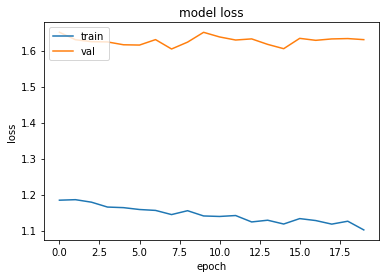

In [242]:
#plotting losses, https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
plt.plot(model_results.history['loss'])
plt.plot(model_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
input_len = 20
target_len = 28


In [20]:
def get_predictions(model, data_source_inputs, data_source_targets):

    predictions = []
    ground_truths = []
    inputs = []
    for i in range(0, data_source_inputs.shape[0], 1):
        res = model.predict(data_source_inputs[i:i+1])
        for j in range(target_len):
            ground_truths.append(data_source_targets[i].squeeze().tolist())
            predictions.append((tf.argmax(res[0,:,:], axis=1)).numpy().tolist())
            if j < 20:
                inputs.append(int(data_source_inputs[i][j]))
            
    return inputs, ground_truths, predictions

In [21]:
inputs_list, target_list, preds_list = get_predictions(model, test_data_inputs, test_data_targets)

In [64]:
len(inputs_list)

36940

In [236]:
import math
def calculate_eucledian_mse(targets, preds):
  err = 0
  for indx in range(0, len(targets)):
    x_target = targets[indx] % 100
    y_target = targets[indx] / 100

    x_preds = preds[indx] % 100
    y_preds = preds[indx] / 100

    dist = math.hypot(x_target - x_preds, y_target - y_preds)
    err += dist
  return (err / len(targets))

In [248]:
calculate_eucledian_mse(target_list, preds_list)

0.735078117832021

In [245]:
import numpy as np
import matplotlib.pyplot as plt
import time

def vis_trajectory_scatter(lag_time = 1.0):
  #input_list, target_list, preds_list = get_predictions(best_model, data_src_inputs, data_src_targets)

    min_val, max_val = 0, 100

    # fig, ax = plt.subplots()
    plt.figure(figsize=(3,3))

    xy_inputs = []
    xy_preds = []
    xy_target = []

    for inp in inputs_list:
      x = inp % 100
      y = inp / 100 

      xy_inputs.append([x, y])

    for inp in preds_list:
      x = inp % 100
      y = inp / 100 
      xy_preds.append([x, y])

    for inp in target_list:
      x = inp % 100
      y = inp / 100 
      xy_target.append([x, y])

    x_inp, y_inp = zip(*xy_inputs)
    x_tar, y_tar = zip(*xy_target)
    x_pred, y_pred = zip(*xy_preds)

    for num_of_plots in range(0,200,1):
        inp_index = 20 * num_of_plots
        pred_ind = 28 * num_of_plots
        
        plot_x_inp, plot_y_inp, plot_x_pred, plot_y_pred, plot_x_gt, plot_y_gt = [], [], [], [], [], []

        for i in range(inp_index - 20, inp_index, 1):
            plot_x_inp.append(x_inp[i])
            plot_y_inp.append(y_inp[i])
        for i in range(pred_ind - 28, pred_ind, 1):
            plot_x_pred.append(x_pred[i])
            plot_y_pred.append(y_pred[i])
            plot_x_gt.append(x_tar[i])
            plot_y_gt.append(y_tar[i])

        plt.scatter(plot_x_inp,plot_y_inp)
        plt.scatter(plot_x_gt,plot_y_gt, color='r')
        plt.scatter(plot_x_pred,plot_y_pred)

        plt.xlim(0, 100)
        plt.ylim(0, 100)

        plt.show()
        """
        print("Input: ", xy_inputs)
        print("Preds: ", xy_preds)
        print("Truth: ", xy_target)
        """
        time.sleep(lag_time)

NameError: name 'input_list' is not defined

In [261]:
import numpy as np
import matplotlib.pyplot as plt

def vis_trajectory_scatter(input_list, target_list, preds_list, lag_time = 1.0):
    plt.figure(figsize=(3,3))
    for i in range(0, len(input_list)):

        inputs = input_list[i]
        targets = target_list[i]
        preds = preds_list[i]
        
        xy_inputs = []
        xy_preds = []
        xy_target = []

        x = inputs % 100
        y = inputs / 100 
        xy_inputs.extend([x, y])

        x = preds % 100
        y = preds / 100 
        xy_preds.extend([x, y])

        x = targets % 100
        y = targets / 100 
        xy_target.extend([x, y])
    print(xy_inputs)
    print(xy_preds)
    print(xy_target)
    """

    x_inp, y_inp = zip(*xy_inputs)
    x_tar, y_tar = zip(*xy_target)
    x_pred, y_pred = zip(*xy_preds)

    plt.scatter(x_inp,y_inp)
    plt.scatter(x_tar,y_tar, color='r')
    plt.scatter(x_pred,y_pred)

    plt.xlim(0, 100)
    plt.ylim(0, 100)

    plt.show()
    print("Input: ", xy_inputs)
    print("Preds: ", xy_preds)
    print("Truth: ", xy_target)
    time.sleep(lag_time)
    """

In [262]:
vis_trajectory_scatter(inputs_list, target_list, preds_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660


5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5516
5517
5518
5519
5520
5521
5522
5523
5524
5525
5526
5527
5528
5529
5530
5531
5532
5533
5534
5535
5536
5537
5538
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553
5554
5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5571
5572
5573
5574
5575
5576
5577
5578
5579
5580
5581
5582
5583
5584
5585
5586
5587
5588
5589
5590
5591
5592
5593
5594
5595
5596
5597
5598
5599
5600
5601
5602
5603
5604
5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
5619
5620
5621
5622
5623
5624
5625
5626
5627
5628
5629
5630
5631
5632
5633
5634
5635
5636
5637
5638
5639
5640
5641
5642
5643
5644
5645
5646
5647
5648
5649
5650
5651
5652
5653
5654
5655
5656
5657
5658
5659
5660
5661
5662
5663
5664
5665


8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746
8747
8748
8749
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759
8760
8761
8762
8763
8764
8765
8766
8767
8768
8769
8770
8771
8772
8773
8774
8775
8776
8777
8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
8806
8807
8808
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842
8843
8844
8845
8846
8847
8848
8849
8850
8851
8852
8853
8854
8855
8856


10574
10575
10576
10577
10578
10579
10580
10581
10582
10583
10584
10585
10586
10587
10588
10589
10590
10591
10592
10593
10594
10595
10596
10597
10598
10599
10600
10601
10602
10603
10604
10605
10606
10607
10608
10609
10610
10611
10612
10613
10614
10615
10616
10617
10618
10619
10620
10621
10622
10623
10624
10625
10626
10627
10628
10629
10630
10631
10632
10633
10634
10635
10636
10637
10638
10639
10640
10641
10642
10643
10644
10645
10646
10647
10648
10649
10650
10651
10652
10653
10654
10655
10656
10657
10658
10659
10660
10661
10662
10663
10664
10665
10666
10667
10668
10669
10670
10671
10672
10673
10674
10675
10676
10677
10678
10679
10680
10681
10682
10683
10684
10685
10686
10687
10688
10689
10690
10691
10692
10693
10694
10695
10696
10697
10698
10699
10700
10701
10702
10703
10704
10705
10706
10707
10708
10709
10710
10711
10712
10713
10714
10715
10716
10717
10718
10719
10720
10721
10722
10723
10724
10725
10726
10727
10728
10729
10730
10731
10732
10733
10734
10735
10736
10737
10738
10739
1074

12519
12520
12521
12522
12523
12524
12525
12526
12527
12528
12529
12530
12531
12532
12533
12534
12535
12536
12537
12538
12539
12540
12541
12542
12543
12544
12545
12546
12547
12548
12549
12550
12551
12552
12553
12554
12555
12556
12557
12558
12559
12560
12561
12562
12563
12564
12565
12566
12567
12568
12569
12570
12571
12572
12573
12574
12575
12576
12577
12578
12579
12580
12581
12582
12583
12584
12585
12586
12587
12588
12589
12590
12591
12592
12593
12594
12595
12596
12597
12598
12599
12600
12601
12602
12603
12604
12605
12606
12607
12608
12609
12610
12611
12612
12613
12614
12615
12616
12617
12618
12619
12620
12621
12622
12623
12624
12625
12626
12627
12628
12629
12630
12631
12632
12633
12634
12635
12636
12637
12638
12639
12640
12641
12642
12643
12644
12645
12646
12647
12648
12649
12650
12651
12652
12653
12654
12655
12656
12657
12658
12659
12660
12661
12662
12663
12664
12665
12666
12667
12668
12669
12670
12671
12672
12673
12674
12675
12676
12677
12678
12679
12680
12681
12682
12683
12684
1268

14463
14464
14465
14466
14467
14468
14469
14470
14471
14472
14473
14474
14475
14476
14477
14478
14479
14480
14481
14482
14483
14484
14485
14486
14487
14488
14489
14490
14491
14492
14493
14494
14495
14496
14497
14498
14499
14500
14501
14502
14503
14504
14505
14506
14507
14508
14509
14510
14511
14512
14513
14514
14515
14516
14517
14518
14519
14520
14521
14522
14523
14524
14525
14526
14527
14528
14529
14530
14531
14532
14533
14534
14535
14536
14537
14538
14539
14540
14541
14542
14543
14544
14545
14546
14547
14548
14549
14550
14551
14552
14553
14554
14555
14556
14557
14558
14559
14560
14561
14562
14563
14564
14565
14566
14567
14568
14569
14570
14571
14572
14573
14574
14575
14576
14577
14578
14579
14580
14581
14582
14583
14584
14585
14586
14587
14588
14589
14590
14591
14592
14593
14594
14595
14596
14597
14598
14599
14600
14601
14602
14603
14604
14605
14606
14607
14608
14609
14610
14611
14612
14613
14614
14615
14616
14617
14618
14619
14620
14621
14622
14623
14624
14625
14626
14627
14628
1462

15907
15908
15909
15910
15911
15912
15913
15914
15915
15916
15917
15918
15919
15920
15921
15922
15923
15924
15925
15926
15927
15928
15929
15930
15931
15932
15933
15934
15935
15936
15937
15938
15939
15940
15941
15942
15943
15944
15945
15946
15947
15948
15949
15950
15951
15952
15953
15954
15955
15956
15957
15958
15959
15960
15961
15962
15963
15964
15965
15966
15967
15968
15969
15970
15971
15972
15973
15974
15975
15976
15977
15978
15979
15980
15981
15982
15983
15984
15985
15986
15987
15988
15989
15990
15991
15992
15993
15994
15995
15996
15997
15998
15999
16000
16001
16002
16003
16004
16005
16006
16007
16008
16009
16010
16011
16012
16013
16014
16015
16016
16017
16018
16019
16020
16021
16022
16023
16024
16025
16026
16027
16028
16029
16030
16031
16032
16033
16034
16035
16036
16037
16038
16039
16040
16041
16042
16043
16044
16045
16046
16047
16048
16049
16050
16051
16052
16053
16054
16055
16056
16057
16058
16059
16060
16061
16062
16063
16064
16065
16066
16067
16068
16069
16070
16071
16072
1607

17995
17996
17997
17998
17999
18000
18001
18002
18003
18004
18005
18006
18007
18008
18009
18010
18011
18012
18013
18014
18015
18016
18017
18018
18019
18020
18021
18022
18023
18024
18025
18026
18027
18028
18029
18030
18031
18032
18033
18034
18035
18036
18037
18038
18039
18040
18041
18042
18043
18044
18045
18046
18047
18048
18049
18050
18051
18052
18053
18054
18055
18056
18057
18058
18059
18060
18061
18062
18063
18064
18065
18066
18067
18068
18069
18070
18071
18072
18073
18074
18075
18076
18077
18078
18079
18080
18081
18082
18083
18084
18085
18086
18087
18088
18089
18090
18091
18092
18093
18094
18095
18096
18097
18098
18099
18100
18101
18102
18103
18104
18105
18106
18107
18108
18109
18110
18111
18112
18113
18114
18115
18116
18117
18118
18119
18120
18121
18122
18123
18124
18125
18126
18127
18128
18129
18130
18131
18132
18133
18134
18135
18136
18137
18138
18139
18140
18141
18142
18143
18144
18145
18146
18147
18148
18149
18150
18151
18152
18153
18154
18155
18156
18157
18158
18159
18160
1816

19651
19652
19653
19654
19655
19656
19657
19658
19659
19660
19661
19662
19663
19664
19665
19666
19667
19668
19669
19670
19671
19672
19673
19674
19675
19676
19677
19678
19679
19680
19681
19682
19683
19684
19685
19686
19687
19688
19689
19690
19691
19692
19693
19694
19695
19696
19697
19698
19699
19700
19701
19702
19703
19704
19705
19706
19707
19708
19709
19710
19711
19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798
19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
19810
19811
19812
19813
19814
19815
19816
1981

21858
21859
21860
21861
21862
21863
21864
21865
21866
21867
21868
21869
21870
21871
21872
21873
21874
21875
21876
21877
21878
21879
21880
21881
21882
21883
21884
21885
21886
21887
21888
21889
21890
21891
21892
21893
21894
21895
21896
21897
21898
21899
21900
21901
21902
21903
21904
21905
21906
21907
21908
21909
21910
21911
21912
21913
21914
21915
21916
21917
21918
21919
21920
21921
21922
21923
21924
21925
21926
21927
21928
21929
21930
21931
21932
21933
21934
21935
21936
21937
21938
21939
21940
21941
21942
21943
21944
21945
21946
21947
21948
21949
21950
21951
21952
21953
21954
21955
21956
21957
21958
21959
21960
21961
21962
21963
21964
21965
21966
21967
21968
21969
21970
21971
21972
21973
21974
21975
21976
21977
21978
21979
21980
21981
21982
21983
21984
21985
21986
21987
21988
21989
21990
21991
21992
21993
21994
21995
21996
21997
21998
21999
22000
22001
22002
22003
22004
22005
22006
22007
22008
22009
22010
22011
22012
22013
22014
22015
22016
22017
22018
22019
22020
22021
22022
22023
2202

23525
23526
23527
23528
23529
23530
23531
23532
23533
23534
23535
23536
23537
23538
23539
23540
23541
23542
23543
23544
23545
23546
23547
23548
23549
23550
23551
23552
23553
23554
23555
23556
23557
23558
23559
23560
23561
23562
23563
23564
23565
23566
23567
23568
23569
23570
23571
23572
23573
23574
23575
23576
23577
23578
23579
23580
23581
23582
23583
23584
23585
23586
23587
23588
23589
23590
23591
23592
23593
23594
23595
23596
23597
23598
23599
23600
23601
23602
23603
23604
23605
23606
23607
23608
23609
23610
23611
23612
23613
23614
23615
23616
23617
23618
23619
23620
23621
23622
23623
23624
23625
23626
23627
23628
23629
23630
23631
23632
23633
23634
23635
23636
23637
23638
23639
23640
23641
23642
23643
23644
23645
23646
23647
23648
23649
23650
23651
23652
23653
23654
23655
23656
23657
23658
23659
23660
23661
23662
23663
23664
23665
23666
23667
23668
23669
23670
23671
23672
23673
23674
23675
23676
23677
23678
23679
23680
23681
23682
23683
23684
23685
23686
23687
23688
23689
23690
2369

25561
25562
25563
25564
25565
25566
25567
25568
25569
25570
25571
25572
25573
25574
25575
25576
25577
25578
25579
25580
25581
25582
25583
25584
25585
25586
25587
25588
25589
25590
25591
25592
25593
25594
25595
25596
25597
25598
25599
25600
25601
25602
25603
25604
25605
25606
25607
25608
25609
25610
25611
25612
25613
25614
25615
25616
25617
25618
25619
25620
25621
25622
25623
25624
25625
25626
25627
25628
25629
25630
25631
25632
25633
25634
25635
25636
25637
25638
25639
25640
25641
25642
25643
25644
25645
25646
25647
25648
25649
25650
25651
25652
25653
25654
25655
25656
25657
25658
25659
25660
25661
25662
25663
25664
25665
25666
25667
25668
25669
25670
25671
25672
25673
25674
25675
25676
25677
25678
25679
25680
25681
25682
25683
25684
25685
25686
25687
25688
25689
25690
25691
25692
25693
25694
25695
25696
25697
25698
25699
25700
25701
25702
25703
25704
25705
25706
25707
25708
25709
25710
25711
25712
25713
25714
25715
25716
25717
25718
25719
25720
25721
25722
25723
25724
25725
25726
2572

27844
27845
27846
27847
27848
27849
27850
27851
27852
27853
27854
27855
27856
27857
27858
27859
27860
27861
27862
27863
27864
27865
27866
27867
27868
27869
27870
27871
27872
27873
27874
27875
27876
27877
27878
27879
27880
27881
27882
27883
27884
27885
27886
27887
27888
27889
27890
27891
27892
27893
27894
27895
27896
27897
27898
27899
27900
27901
27902
27903
27904
27905
27906
27907
27908
27909
27910
27911
27912
27913
27914
27915
27916
27917
27918
27919
27920
27921
27922
27923
27924
27925
27926
27927
27928
27929
27930
27931
27932
27933
27934
27935
27936
27937
27938
27939
27940
27941
27942
27943
27944
27945
27946
27947
27948
27949
27950
27951
27952
27953
27954
27955
27956
27957
27958
27959
27960
27961
27962
27963
27964
27965
27966
27967
27968
27969
27970
27971
27972
27973
27974
27975
27976
27977
27978
27979
27980
27981
27982
27983
27984
27985
27986
27987
27988
27989
27990
27991
27992
27993
27994
27995
27996
27997
27998
27999
28000
28001
28002
28003
28004
28005
28006
28007
28008
28009
2801

29394
29395
29396
29397
29398
29399
29400
29401
29402
29403
29404
29405
29406
29407
29408
29409
29410
29411
29412
29413
29414
29415
29416
29417
29418
29419
29420
29421
29422
29423
29424
29425
29426
29427
29428
29429
29430
29431
29432
29433
29434
29435
29436
29437
29438
29439
29440
29441
29442
29443
29444
29445
29446
29447
29448
29449
29450
29451
29452
29453
29454
29455
29456
29457
29458
29459
29460
29461
29462
29463
29464
29465
29466
29467
29468
29469
29470
29471
29472
29473
29474
29475
29476
29477
29478
29479
29480
29481
29482
29483
29484
29485
29486
29487
29488
29489
29490
29491
29492
29493
29494
29495
29496
29497
29498
29499
29500
29501
29502
29503
29504
29505
29506
29507
29508
29509
29510
29511
29512
29513
29514
29515
29516
29517
29518
29519
29520
29521
29522
29523
29524
29525
29526
29527
29528
29529
29530
29531
29532
29533
29534
29535
29536
29537
29538
29539
29540
29541
29542
29543
29544
29545
29546
29547
29548
29549
29550
29551
29552
29553
29554
29555
29556
29557
29558
29559
2956

31293
31294
31295
31296
31297
31298
31299
31300
31301
31302
31303
31304
31305
31306
31307
31308
31309
31310
31311
31312
31313
31314
31315
31316
31317
31318
31319
31320
31321
31322
31323
31324
31325
31326
31327
31328
31329
31330
31331
31332
31333
31334
31335
31336
31337
31338
31339
31340
31341
31342
31343
31344
31345
31346
31347
31348
31349
31350
31351
31352
31353
31354
31355
31356
31357
31358
31359
31360
31361
31362
31363
31364
31365
31366
31367
31368
31369
31370
31371
31372
31373
31374
31375
31376
31377
31378
31379
31380
31381
31382
31383
31384
31385
31386
31387
31388
31389
31390
31391
31392
31393
31394
31395
31396
31397
31398
31399
31400
31401
31402
31403
31404
31405
31406
31407
31408
31409
31410
31411
31412
31413
31414
31415
31416
31417
31418
31419
31420
31421
31422
31423
31424
31425
31426
31427
31428
31429
31430
31431
31432
31433
31434
31435
31436
31437
31438
31439
31440
31441
31442
31443
31444
31445
31446
31447
31448
31449
31450
31451
31452
31453
31454
31455
31456
31457
31458
3145

32867
32868
32869
32870
32871
32872
32873
32874
32875
32876
32877
32878
32879
32880
32881
32882
32883
32884
32885
32886
32887
32888
32889
32890
32891
32892
32893
32894
32895
32896
32897
32898
32899
32900
32901
32902
32903
32904
32905
32906
32907
32908
32909
32910
32911
32912
32913
32914
32915
32916
32917
32918
32919
32920
32921
32922
32923
32924
32925
32926
32927
32928
32929
32930
32931
32932
32933
32934
32935
32936
32937
32938
32939
32940
32941
32942
32943
32944
32945
32946
32947
32948
32949
32950
32951
32952
32953
32954
32955
32956
32957
32958
32959
32960
32961
32962
32963
32964
32965
32966
32967
32968
32969
32970
32971
32972
32973
32974
32975
32976
32977
32978
32979
32980
32981
32982
32983
32984
32985
32986
32987
32988
32989
32990
32991
32992
32993
32994
32995
32996
32997
32998
32999
33000
33001
33002
33003
33004
33005
33006
33007
33008
33009
33010
33011
33012
33013
33014
33015
33016
33017
33018
33019
33020
33021
33022
33023
33024
33025
33026
33027
33028
33029
33030
33031
33032
3303

34612
34613
34614
34615
34616
34617
34618
34619
34620
34621
34622
34623
34624
34625
34626
34627
34628
34629
34630
34631
34632
34633
34634
34635
34636
34637
34638
34639
34640
34641
34642
34643
34644
34645
34646
34647
34648
34649
34650
34651
34652
34653
34654
34655
34656
34657
34658
34659
34660
34661
34662
34663
34664
34665
34666
34667
34668
34669
34670
34671
34672
34673
34674
34675
34676
34677
34678
34679
34680
34681
34682
34683
34684
34685
34686
34687
34688
34689
34690
34691
34692
34693
34694
34695
34696
34697
34698
34699
34700
34701
34702
34703
34704
34705
34706
34707
34708
34709
34710
34711
34712
34713
34714
34715
34716
34717
34718
34719
34720
34721
34722
34723
34724
34725
34726
34727
34728
34729
34730
34731
34732
34733
34734
34735
34736
34737
34738
34739
34740
34741
34742
34743
34744
34745
34746
34747
34748
34749
34750
34751
34752
34753
34754
34755
34756
34757
34758
34759
34760
34761
34762
34763
34764
34765
34766
34767
34768
34769
34770
34771
34772
34773
34774
34775
34776
34777
3477

36621
36622
36623
36624
36625
36626
36627
36628
36629
36630
36631
36632
36633
36634
36635
36636
36637
36638
36639
36640
36641
36642
36643
36644
36645
36646
36647
36648
36649
36650
36651
36652
36653
36654
36655
36656
36657
36658
36659
36660
36661
36662
36663
36664
36665
36666
36667
36668
36669
36670
36671
36672
36673
36674
36675
36676
36677
36678
36679
36680
36681
36682
36683
36684
36685
36686
36687
36688
36689
36690
36691
36692
36693
36694
36695
36696
36697
36698
36699
36700
36701
36702
36703
36704
36705
36706
36707
36708
36709
36710
36711
36712
36713
36714
36715
36716
36717
36718
36719
36720
36721
36722
36723
36724
36725
36726
36727
36728
36729
36730
36731
36732
36733
36734
36735
36736
36737
36738
36739
36740
36741
36742
36743
36744
36745
36746
36747
36748
36749
36750
36751
36752
36753
36754
36755
36756
36757
36758
36759
36760
36761
36762
36763
36764
36765
36766
36767
36768
36769
36770
36771
36772
36773
36774
36775
36776
36777
36778
36779
36780
36781
36782
36783
36784
36785
36786
3678

<Figure size 216x216 with 0 Axes>

In [71]:
import numpy as np
import matplotlib.pyplot as plt

def vis_trajectory_scatter(input_list, target_list, preds_list, lag_time = 1.0):
  
  for i in range(1 ,1000, 20):

    plt.figure(figsize=(5,5))
    #inputs = input_list[i]
    targets = target_list[i]
    preds = preds_list[i]

    xy_inputs = []
    xy_preds = []
    xy_target = []

    """
    for inp in inputs:
      x = inp % 100
      y = inp / 100 

      xy_inputs.append([x, y])
    """
    for inp in preds:
      x = inp % 100
      y = inp / 100 
      xy_preds.append([x, y])

    for inp in targets:
      x = inp % 100
      y = inp / 100 
      xy_target.append([x, y])

    #x_inp, y_inp = zip(*xy_inputs)
    x_tar, y_tar = zip(*xy_target)
    x_pred, y_pred = zip(*xy_preds)

    #plt.scatter(x_inp,y_inp)
    plt.scatter(x_tar,y_tar, color='r')
    plt.scatter(x_pred,y_pred)

    plt.xlim(0, 100)
    plt.ylim(0, 100)

    plt.show()
    print("Input: ", xy_inputs)
    print("Preds: ", xy_preds)
    print("Truth: ", xy_target)


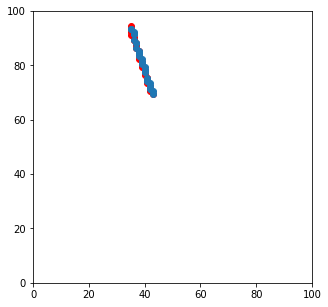

Input:  []
Preds:  [[43, 69.43], [43, 70.43], [42, 71.42], [42, 72.42], [42, 73.42], [41, 74.41], [41, 74.41], [41, 75.41], [40, 77.4], [40, 77.4], [40, 78.4], [40, 79.4], [39, 80.39], [39, 81.39], [39, 82.39], [38, 83.38], [38, 84.38], [38, 84.38], [38, 85.38], [37, 86.37], [37, 88.37], [37, 88.37], [36, 89.36], [36, 91.36], [36, 91.36], [36, 92.36], [35, 93.35], [35, 93.35]]
Truth:  [[43, 69.43], [42, 70.42], [42, 71.42], [42, 72.42], [41, 73.41], [41, 74.41], [41, 75.41], [41, 75.41], [40, 76.4], [40, 77.4], [40, 78.4], [39, 79.39], [39, 80.39], [39, 81.39], [38, 82.38], [38, 83.38], [38, 84.38], [38, 85.38], [37, 86.37], [37, 87.37], [37, 88.37], [36, 89.36], [36, 89.36], [36, 90.36], [35, 91.35], [35, 92.35], [35, 93.35], [35, 94.35]]


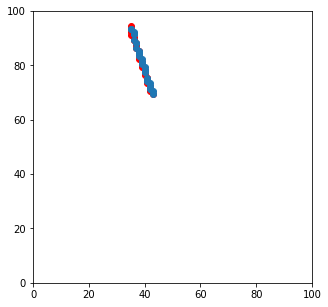

Input:  []
Preds:  [[43, 69.43], [43, 70.43], [42, 71.42], [42, 72.42], [42, 73.42], [41, 74.41], [41, 74.41], [41, 75.41], [40, 77.4], [40, 77.4], [40, 78.4], [40, 79.4], [39, 80.39], [39, 81.39], [39, 82.39], [38, 83.38], [38, 84.38], [38, 84.38], [38, 85.38], [37, 86.37], [37, 88.37], [37, 88.37], [36, 89.36], [36, 91.36], [36, 91.36], [36, 92.36], [35, 93.35], [35, 93.35]]
Truth:  [[43, 69.43], [42, 70.42], [42, 71.42], [42, 72.42], [41, 73.41], [41, 74.41], [41, 75.41], [41, 75.41], [40, 76.4], [40, 77.4], [40, 78.4], [39, 79.39], [39, 80.39], [39, 81.39], [38, 82.38], [38, 83.38], [38, 84.38], [38, 85.38], [37, 86.37], [37, 87.37], [37, 88.37], [36, 89.36], [36, 89.36], [36, 90.36], [35, 91.35], [35, 92.35], [35, 93.35], [35, 94.35]]


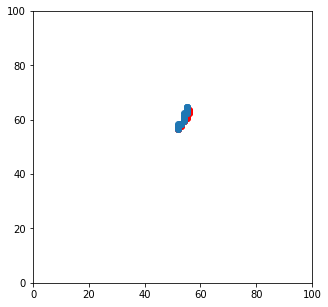

Input:  []
Preds:  [[52, 57.52], [52, 56.52], [52, 56.52], [52, 58.52], [53, 58.53], [53, 58.53], [53, 58.53], [53, 58.53], [54, 59.54], [54, 60.54], [54, 60.54], [54, 60.54], [54, 60.54], [54, 60.54], [54, 61.54], [54, 61.54], [54, 61.54], [54, 62.54], [55, 62.55], [55, 62.55], [55, 63.55], [55, 63.55], [55, 63.55], [55, 63.55], [55, 64.55], [55, 64.55], [55, 64.55], [55, 64.55]]
Truth:  [[52, 56.52], [52, 56.52], [52, 56.52], [52, 57.52], [52, 57.52], [53, 57.53], [53, 57.53], [53, 58.53], [53, 58.53], [53, 58.53], [53, 58.53], [54, 59.54], [54, 59.54], [54, 59.54], [54, 60.54], [54, 60.54], [54, 60.54], [55, 60.55], [55, 60.55], [55, 61.55], [55, 61.55], [55, 61.55], [55, 62.55], [55, 62.55], [56, 62.56], [56, 62.56], [56, 63.56], [56, 63.56]]


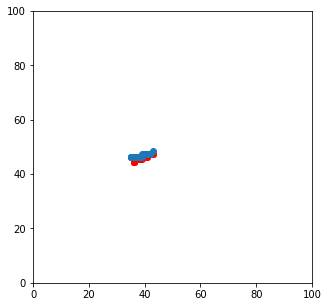

Input:  []
Preds:  [[43, 48.43], [42, 47.42], [42, 47.42], [42, 47.42], [42, 47.42], [41, 47.41], [41, 47.41], [41, 47.41], [40, 47.4], [40, 47.4], [40, 47.4], [40, 47.4], [39, 46.39], [39, 47.39], [38, 46.38], [38, 46.38], [37, 46.37], [37, 46.37], [37, 46.37], [37, 46.37], [37, 46.37], [37, 46.37], [36, 46.36], [36, 46.36], [35, 46.35], [35, 46.35], [35, 46.35], [35, 46.35]]
Truth:  [[43, 47.43], [43, 47.43], [42, 47.42], [42, 47.42], [42, 47.42], [41, 47.41], [41, 47.41], [41, 46.41], [41, 46.41], [40, 46.4], [40, 46.4], [40, 46.4], [40, 46.4], [39, 46.39], [39, 46.39], [39, 46.39], [39, 45.39], [38, 45.38], [38, 45.38], [38, 45.38], [38, 45.38], [37, 45.37], [37, 45.37], [37, 45.37], [36, 44.36], [36, 44.36], [36, 44.36], [36, 44.36]]


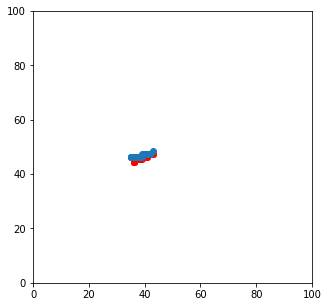

Input:  []
Preds:  [[43, 48.43], [42, 47.42], [42, 47.42], [42, 47.42], [42, 47.42], [41, 47.41], [41, 47.41], [41, 47.41], [40, 47.4], [40, 47.4], [40, 47.4], [40, 47.4], [39, 46.39], [39, 47.39], [38, 46.38], [38, 46.38], [37, 46.37], [37, 46.37], [37, 46.37], [37, 46.37], [37, 46.37], [37, 46.37], [36, 46.36], [36, 46.36], [35, 46.35], [35, 46.35], [35, 46.35], [35, 46.35]]
Truth:  [[43, 47.43], [43, 47.43], [42, 47.42], [42, 47.42], [42, 47.42], [41, 47.41], [41, 47.41], [41, 46.41], [41, 46.41], [40, 46.4], [40, 46.4], [40, 46.4], [40, 46.4], [39, 46.39], [39, 46.39], [39, 46.39], [39, 45.39], [38, 45.38], [38, 45.38], [38, 45.38], [38, 45.38], [37, 45.37], [37, 45.37], [37, 45.37], [36, 44.36], [36, 44.36], [36, 44.36], [36, 44.36]]


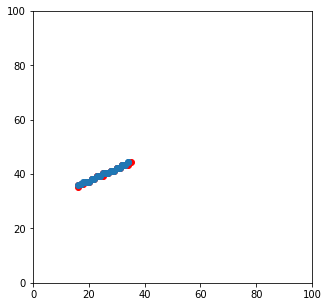

Input:  []
Preds:  [[34, 44.34], [34, 44.34], [33, 43.33], [32, 43.32], [32, 43.32], [31, 42.31], [30, 42.3], [30, 42.3], [29, 41.29], [28, 41.28], [28, 41.28], [27, 40.27], [26, 40.26], [26, 40.26], [25, 40.25], [24, 39.24], [24, 39.24], [23, 39.23], [22, 38.22], [21, 38.21], [21, 38.21], [20, 37.2], [19, 37.19], [19, 37.19], [18, 37.18], [17, 36.17], [17, 36.17], [16, 36.16]]
Truth:  [[35, 44.35], [34, 43.34], [33, 43.33], [32, 43.32], [32, 43.32], [31, 42.31], [30, 42.3], [30, 42.3], [29, 41.29], [28, 41.28], [28, 41.28], [27, 40.27], [26, 40.26], [25, 40.25], [25, 39.25], [24, 39.24], [23, 39.23], [23, 39.23], [22, 38.22], [21, 38.21], [21, 38.21], [20, 37.2], [19, 37.19], [19, 37.19], [18, 36.18], [17, 36.17], [16, 36.16], [16, 35.16]]


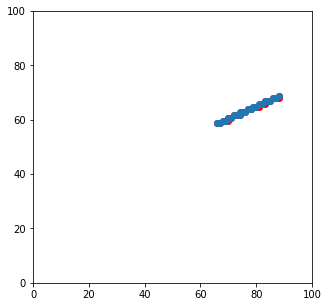

Input:  []
Preds:  [[66, 58.66], [67, 58.67], [68, 59.68], [69, 59.69], [69, 59.69], [70, 60.7], [71, 60.71], [72, 61.72], [73, 61.73], [74, 61.74], [74, 62.74], [75, 62.75], [76, 62.76], [77, 63.77], [78, 63.78], [78, 63.78], [79, 64.79], [80, 64.8], [81, 65.81], [82, 65.82], [82, 65.82], [83, 66.83], [84, 66.84], [85, 66.85], [86, 67.86], [87, 67.87], [87, 67.87], [88, 68.88]]
Truth:  [[66, 58.66], [67, 58.67], [68, 59.68], [69, 59.69], [70, 59.7], [70, 60.7], [71, 60.71], [72, 61.72], [73, 61.73], [74, 61.74], [75, 62.75], [75, 62.75], [76, 62.76], [77, 63.77], [78, 63.78], [78, 63.78], [79, 64.79], [80, 64.8], [81, 64.81], [82, 65.82], [83, 65.83], [83, 66.83], [84, 66.84], [85, 66.85], [86, 67.86], [87, 67.87], [88, 67.88], [88, 68.88]]


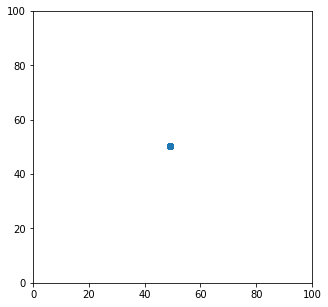

Input:  []
Preds:  [[49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49]]
Truth:  [[49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49]]


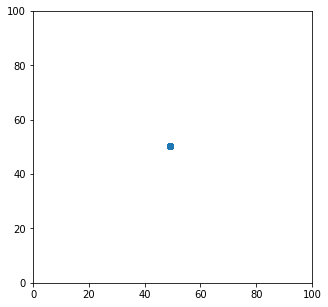

Input:  []
Preds:  [[49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49]]
Truth:  [[49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49]]


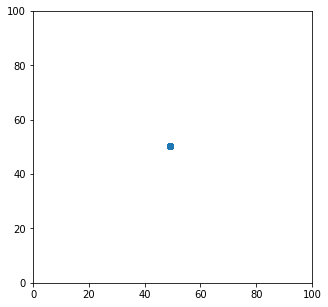

Input:  []
Preds:  [[49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49]]
Truth:  [[49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49]]


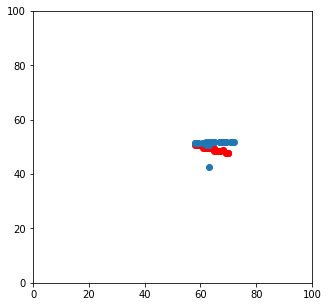

Input:  []
Preds:  [[58, 51.58], [58, 51.58], [59, 51.59], [59, 51.59], [61, 51.61], [61, 51.61], [61, 51.61], [62, 51.62], [62, 50.62], [63, 51.63], [63, 50.63], [64, 51.64], [65, 51.65], [65, 51.65], [65, 51.65], [63, 42.63], [67, 51.67], [67, 51.67], [67, 51.67], [68, 51.68], [68, 51.68], [68, 51.68], [69, 51.69], [69, 51.69], [71, 51.71], [71, 51.71], [71, 51.71], [72, 51.72]]
Truth:  [[58, 50.58], [59, 50.59], [59, 50.59], [60, 50.6], [60, 50.6], [61, 50.61], [61, 49.61], [62, 49.62], [62, 49.62], [62, 49.62], [63, 49.63], [63, 49.63], [64, 49.64], [64, 49.64], [65, 49.65], [65, 48.65], [66, 48.66], [66, 48.66], [67, 48.67], [67, 48.67], [67, 48.67], [68, 48.68], [68, 48.68], [69, 47.69], [69, 47.69], [70, 47.7], [70, 47.7], [70, 47.7]]


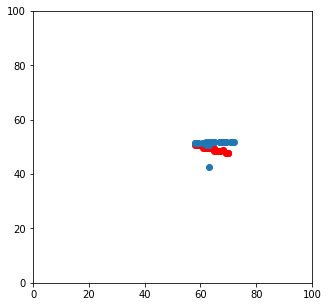

Input:  []
Preds:  [[58, 51.58], [58, 51.58], [59, 51.59], [59, 51.59], [61, 51.61], [61, 51.61], [61, 51.61], [62, 51.62], [62, 50.62], [63, 51.63], [63, 50.63], [64, 51.64], [65, 51.65], [65, 51.65], [65, 51.65], [63, 42.63], [67, 51.67], [67, 51.67], [67, 51.67], [68, 51.68], [68, 51.68], [68, 51.68], [69, 51.69], [69, 51.69], [71, 51.71], [71, 51.71], [71, 51.71], [72, 51.72]]
Truth:  [[58, 50.58], [59, 50.59], [59, 50.59], [60, 50.6], [60, 50.6], [61, 50.61], [61, 49.61], [62, 49.62], [62, 49.62], [62, 49.62], [63, 49.63], [63, 49.63], [64, 49.64], [64, 49.64], [65, 49.65], [65, 48.65], [66, 48.66], [66, 48.66], [67, 48.67], [67, 48.67], [67, 48.67], [68, 48.68], [68, 48.68], [69, 47.69], [69, 47.69], [70, 47.7], [70, 47.7], [70, 47.7]]


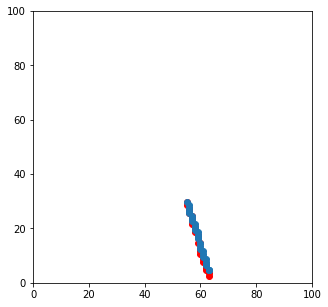

Input:  []
Preds:  [[55, 29.55], [56, 28.56], [56, 27.56], [56, 26.56], [56, 25.56], [57, 24.57], [57, 23.57], [57, 22.57], [58, 21.58], [58, 20.58], [58, 19.58], [59, 18.59], [59, 17.59], [59, 16.59], [59, 16.59], [60, 14.6], [60, 13.6], [60, 12.6], [61, 11.61], [61, 10.61], [61, 9.61], [62, 8.62], [62, 7.62], [62, 6.62], [62, 6.62], [63, 4.63], [63, 4.63], [63, 4.63]]
Truth:  [[55, 29.55], [55, 28.55], [56, 27.56], [56, 26.56], [56, 25.56], [57, 24.57], [57, 23.57], [57, 22.57], [57, 21.57], [58, 20.58], [58, 19.58], [58, 18.58], [59, 17.59], [59, 16.59], [59, 14.59], [60, 14.6], [60, 12.6], [60, 11.6], [60, 10.6], [61, 9.61], [61, 8.61], [61, 7.61], [62, 6.62], [62, 6.62], [62, 5.62], [62, 4.62], [63, 3.63], [63, 2.63]]


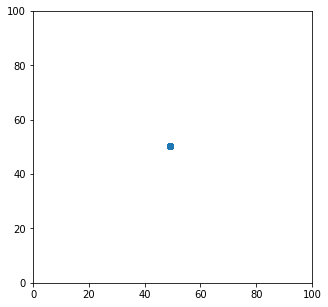

Input:  []
Preds:  [[49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49]]
Truth:  [[49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49]]


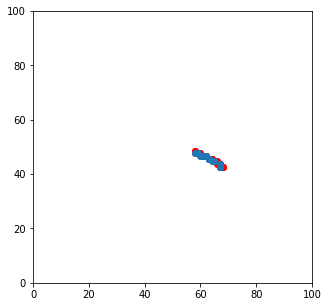

Input:  []
Preds:  [[58, 47.58], [59, 47.59], [59, 47.59], [59, 47.59], [59, 47.59], [60, 46.6], [61, 46.61], [61, 46.61], [61, 46.61], [61, 46.61], [62, 46.62], [62, 46.62], [63, 45.63], [63, 45.63], [63, 45.63], [63, 45.63], [64, 44.64], [65, 44.65], [65, 44.65], [65, 44.65], [65, 44.65], [65, 44.65], [67, 43.67], [67, 43.67], [67, 42.67], [67, 42.67], [67, 42.67], [67, 42.67]]
Truth:  [[58, 48.58], [58, 48.58], [58, 47.58], [59, 47.59], [59, 47.59], [59, 47.59], [60, 47.6], [60, 47.6], [61, 46.61], [61, 46.61], [62, 46.62], [62, 46.62], [62, 46.62], [63, 45.63], [63, 45.63], [64, 45.64], [64, 45.64], [64, 45.64], [65, 44.65], [65, 44.65], [66, 44.66], [66, 44.66], [66, 43.66], [67, 43.67], [67, 43.67], [67, 43.67], [68, 42.68], [68, 42.68]]


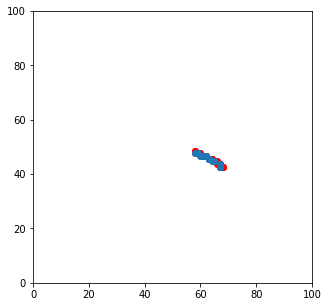

Input:  []
Preds:  [[58, 47.58], [59, 47.59], [59, 47.59], [59, 47.59], [59, 47.59], [60, 46.6], [61, 46.61], [61, 46.61], [61, 46.61], [61, 46.61], [62, 46.62], [62, 46.62], [63, 45.63], [63, 45.63], [63, 45.63], [63, 45.63], [64, 44.64], [65, 44.65], [65, 44.65], [65, 44.65], [65, 44.65], [65, 44.65], [67, 43.67], [67, 43.67], [67, 42.67], [67, 42.67], [67, 42.67], [67, 42.67]]
Truth:  [[58, 48.58], [58, 48.58], [58, 47.58], [59, 47.59], [59, 47.59], [59, 47.59], [60, 47.6], [60, 47.6], [61, 46.61], [61, 46.61], [62, 46.62], [62, 46.62], [62, 46.62], [63, 45.63], [63, 45.63], [64, 45.64], [64, 45.64], [64, 45.64], [65, 44.65], [65, 44.65], [66, 44.66], [66, 44.66], [66, 43.66], [67, 43.67], [67, 43.67], [67, 43.67], [68, 42.68], [68, 42.68]]


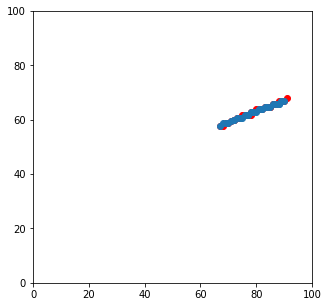

Input:  []
Preds:  [[67, 57.67], [68, 58.68], [69, 58.69], [70, 58.7], [71, 59.71], [72, 59.72], [72, 59.72], [73, 60.73], [74, 60.74], [75, 60.75], [76, 61.76], [77, 61.77], [77, 61.77], [78, 62.78], [79, 62.79], [80, 62.8], [81, 63.81], [82, 63.82], [82, 63.82], [83, 64.83], [84, 64.84], [85, 64.85], [86, 65.86], [87, 65.87], [88, 65.88], [88, 65.88], [89, 66.89], [90, 66.9]]
Truth:  [[67, 57.67], [68, 57.68], [69, 58.69], [70, 58.7], [71, 59.71], [72, 59.72], [72, 59.72], [73, 60.73], [74, 60.74], [75, 61.75], [76, 61.76], [77, 61.77], [78, 61.78], [78, 62.78], [79, 62.79], [80, 63.8], [81, 63.81], [82, 63.82], [83, 64.83], [84, 64.84], [85, 64.85], [85, 64.85], [86, 65.86], [87, 65.87], [88, 66.88], [89, 66.89], [90, 66.9], [91, 67.91]]


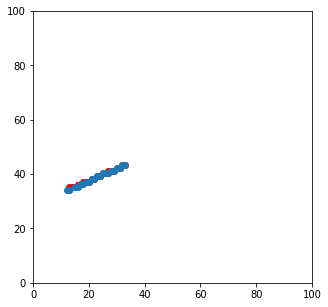

Input:  []
Preds:  [[33, 43.33], [32, 43.32], [31, 42.31], [31, 42.31], [30, 42.3], [29, 41.29], [28, 41.28], [27, 40.27], [27, 40.27], [26, 40.26], [25, 40.25], [24, 39.24], [24, 39.24], [23, 39.23], [22, 38.22], [21, 38.21], [21, 38.21], [20, 37.2], [19, 37.19], [18, 36.18], [17, 36.17], [17, 36.17], [16, 35.16], [15, 35.15], [15, 35.15], [13, 34.13], [13, 34.13], [12, 34.12]]
Truth:  [[33, 43.33], [32, 43.32], [31, 42.31], [31, 42.31], [30, 42.3], [29, 41.29], [28, 41.28], [27, 41.27], [27, 40.27], [26, 40.26], [25, 40.25], [24, 39.24], [24, 39.24], [23, 39.23], [22, 38.22], [22, 38.22], [21, 38.21], [20, 37.2], [19, 37.19], [19, 37.19], [18, 37.18], [17, 36.17], [16, 36.16], [16, 36.16], [15, 35.15], [14, 35.14], [13, 35.13], [13, 34.13]]


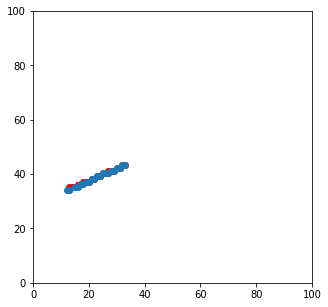

Input:  []
Preds:  [[33, 43.33], [32, 43.32], [31, 42.31], [31, 42.31], [30, 42.3], [29, 41.29], [28, 41.28], [27, 40.27], [27, 40.27], [26, 40.26], [25, 40.25], [24, 39.24], [24, 39.24], [23, 39.23], [22, 38.22], [21, 38.21], [21, 38.21], [20, 37.2], [19, 37.19], [18, 36.18], [17, 36.17], [17, 36.17], [16, 35.16], [15, 35.15], [15, 35.15], [13, 34.13], [13, 34.13], [12, 34.12]]
Truth:  [[33, 43.33], [32, 43.32], [31, 42.31], [31, 42.31], [30, 42.3], [29, 41.29], [28, 41.28], [27, 41.27], [27, 40.27], [26, 40.26], [25, 40.25], [24, 39.24], [24, 39.24], [23, 39.23], [22, 38.22], [22, 38.22], [21, 38.21], [20, 37.2], [19, 37.19], [19, 37.19], [18, 37.18], [17, 36.17], [16, 36.16], [16, 36.16], [15, 35.15], [14, 35.14], [13, 35.13], [13, 34.13]]


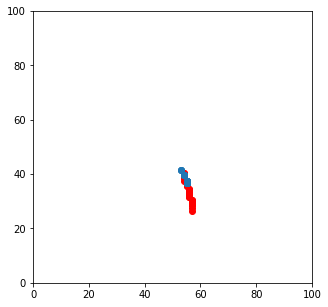

Input:  []
Preds:  [[53, 41.53], [53, 41.53], [53, 41.53], [54, 39.54], [54, 39.54], [54, 39.54], [54, 39.54], [54, 39.54], [54, 39.54], [54, 39.54], [55, 36.55], [55, 36.55], [55, 36.55], [55, 36.55], [55, 36.55], [55, 36.55], [55, 36.55], [55, 36.55], [55, 37.55], [55, 37.55], [55, 37.55], [55, 37.55], [55, 37.55], [55, 37.55], [55, 37.55], [55, 37.55], [55, 37.55], [55, 37.55]]
Truth:  [[54, 40.54], [54, 40.54], [54, 39.54], [54, 39.54], [54, 38.54], [54, 38.54], [54, 37.54], [55, 37.55], [55, 36.55], [55, 36.55], [55, 35.55], [55, 35.55], [56, 34.56], [56, 34.56], [56, 33.56], [56, 33.56], [56, 32.56], [56, 32.56], [56, 31.56], [56, 31.56], [57, 30.57], [57, 30.57], [57, 29.57], [57, 29.57], [57, 28.57], [57, 28.57], [57, 27.57], [57, 26.57]]


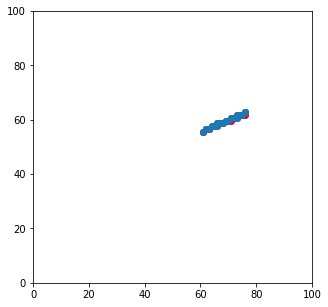

Input:  []
Preds:  [[61, 55.61], [62, 56.62], [62, 56.62], [62, 56.62], [63, 56.63], [63, 56.63], [64, 57.64], [65, 57.65], [65, 57.65], [66, 57.66], [66, 58.66], [67, 58.67], [67, 58.67], [68, 58.68], [69, 59.69], [69, 59.69], [70, 59.7], [70, 59.7], [71, 60.71], [71, 60.71], [72, 60.72], [73, 60.73], [73, 61.73], [74, 61.74], [74, 61.74], [75, 61.75], [76, 62.76], [76, 62.76]]
Truth:  [[61, 55.61], [61, 55.61], [62, 56.62], [62, 56.62], [63, 56.63], [63, 56.63], [64, 57.64], [65, 57.65], [65, 57.65], [66, 57.66], [66, 58.66], [67, 58.67], [67, 58.67], [68, 58.68], [69, 59.69], [69, 59.69], [70, 59.7], [70, 59.7], [71, 59.71], [72, 60.72], [72, 60.72], [73, 60.73], [73, 61.73], [74, 61.74], [74, 61.74], [75, 61.75], [76, 61.76], [76, 62.76]]


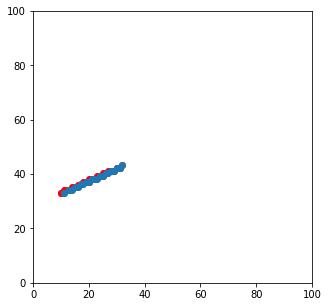

Input:  []
Preds:  [[32, 43.32], [31, 42.31], [31, 42.31], [30, 42.3], [29, 41.29], [28, 41.28], [28, 41.28], [27, 40.27], [26, 40.26], [25, 39.25], [24, 39.24], [24, 39.24], [23, 38.23], [22, 38.22], [21, 38.21], [20, 37.2], [20, 37.2], [19, 37.19], [18, 36.18], [17, 36.17], [16, 35.16], [16, 35.16], [15, 35.15], [14, 34.14], [13, 34.13], [13, 34.13], [11, 33.11], [11, 33.11]]
Truth:  [[32, 43.32], [31, 42.31], [30, 42.3], [30, 42.3], [29, 41.29], [28, 41.28], [27, 41.27], [26, 40.26], [25, 40.25], [25, 39.25], [24, 39.24], [23, 39.23], [22, 38.22], [21, 38.21], [20, 38.2], [20, 37.2], [19, 37.19], [18, 37.18], [17, 36.17], [16, 36.16], [15, 35.15], [15, 35.15], [14, 35.14], [13, 34.13], [12, 34.12], [11, 34.11], [10, 33.1], [10, 33.1]]


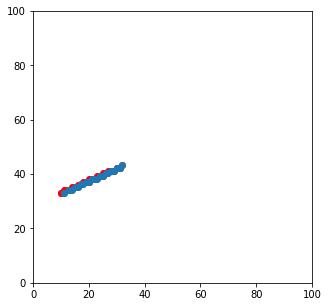

Input:  []
Preds:  [[32, 43.32], [31, 42.31], [31, 42.31], [30, 42.3], [29, 41.29], [28, 41.28], [28, 41.28], [27, 40.27], [26, 40.26], [25, 39.25], [24, 39.24], [24, 39.24], [23, 38.23], [22, 38.22], [21, 38.21], [20, 37.2], [20, 37.2], [19, 37.19], [18, 36.18], [17, 36.17], [16, 35.16], [16, 35.16], [15, 35.15], [14, 34.14], [13, 34.13], [13, 34.13], [11, 33.11], [11, 33.11]]
Truth:  [[32, 43.32], [31, 42.31], [30, 42.3], [30, 42.3], [29, 41.29], [28, 41.28], [27, 41.27], [26, 40.26], [25, 40.25], [25, 39.25], [24, 39.24], [23, 39.23], [22, 38.22], [21, 38.21], [20, 38.2], [20, 37.2], [19, 37.19], [18, 37.18], [17, 36.17], [16, 36.16], [15, 35.15], [15, 35.15], [14, 35.14], [13, 34.13], [12, 34.12], [11, 34.11], [10, 33.1], [10, 33.1]]


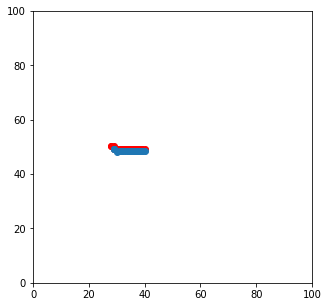

Input:  []
Preds:  [[40, 48.4], [39, 48.39], [39, 48.39], [39, 48.39], [38, 48.38], [38, 48.38], [37, 48.37], [37, 48.37], [36, 48.36], [36, 48.36], [35, 48.35], [35, 48.35], [34, 48.34], [34, 48.34], [34, 48.34], [34, 48.34], [33, 48.33], [32, 48.32], [32, 48.32], [32, 48.32], [31, 48.31], [31, 48.31], [31, 48.31], [31, 48.31], [30, 48.3], [29, 49.29], [29, 49.29], [29, 49.29]]
Truth:  [[40, 49.4], [39, 49.39], [39, 49.39], [38, 49.38], [38, 49.38], [38, 49.38], [37, 49.37], [37, 49.37], [36, 49.36], [36, 49.36], [35, 49.35], [35, 49.35], [34, 49.34], [34, 49.34], [34, 49.34], [33, 49.33], [33, 49.33], [32, 49.32], [32, 49.32], [31, 49.31], [31, 49.31], [31, 49.31], [30, 49.3], [30, 49.3], [29, 49.29], [29, 50.29], [28, 50.28], [28, 50.28]]


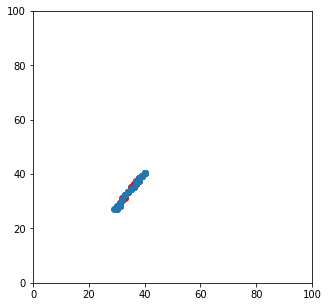

Input:  []
Preds:  [[40, 40.4], [40, 40.4], [40, 40.4], [39, 39.39], [39, 39.39], [38, 38.38], [37, 37.37], [38, 37.38], [37, 36.37], [37, 36.37], [36, 35.36], [36, 35.36], [35, 34.35], [35, 34.35], [34, 33.34], [34, 33.34], [34, 33.34], [33, 32.33], [33, 32.33], [32, 30.32], [32, 30.32], [32, 30.32], [31, 29.31], [31, 28.31], [31, 28.31], [30, 28.3], [30, 27.3], [29, 27.29]]
Truth:  [[40, 40.4], [40, 40.4], [39, 39.39], [39, 39.39], [38, 38.38], [38, 38.38], [38, 37.38], [37, 37.37], [37, 36.37], [36, 36.36], [36, 36.36], [36, 35.36], [35, 35.35], [35, 34.35], [35, 34.35], [34, 33.34], [34, 33.34], [33, 32.33], [33, 32.33], [33, 31.33], [32, 31.32], [32, 30.32], [32, 30.32], [31, 29.31], [31, 29.31], [31, 28.31], [30, 28.3], [30, 27.3]]


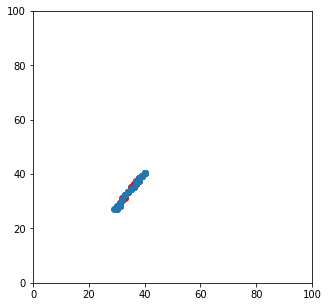

Input:  []
Preds:  [[40, 40.4], [40, 40.4], [40, 40.4], [39, 39.39], [39, 39.39], [38, 38.38], [37, 37.37], [38, 37.38], [37, 36.37], [37, 36.37], [36, 35.36], [36, 35.36], [35, 34.35], [35, 34.35], [34, 33.34], [34, 33.34], [34, 33.34], [33, 32.33], [33, 32.33], [32, 30.32], [32, 30.32], [32, 30.32], [31, 29.31], [31, 28.31], [31, 28.31], [30, 28.3], [30, 27.3], [29, 27.29]]
Truth:  [[40, 40.4], [40, 40.4], [39, 39.39], [39, 39.39], [38, 38.38], [38, 38.38], [38, 37.38], [37, 37.37], [37, 36.37], [36, 36.36], [36, 36.36], [36, 35.36], [35, 35.35], [35, 34.35], [35, 34.35], [34, 33.34], [34, 33.34], [33, 32.33], [33, 32.33], [33, 31.33], [32, 31.32], [32, 30.32], [32, 30.32], [31, 29.31], [31, 29.31], [31, 28.31], [30, 28.3], [30, 27.3]]


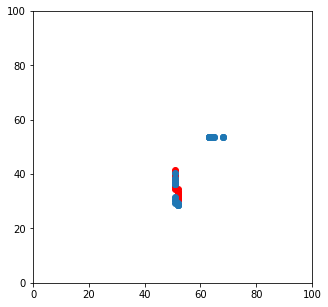

Input:  []
Preds:  [[51, 40.51], [51, 38.51], [51, 37.51], [51, 36.51], [51, 36.51], [51, 36.51], [63, 53.63], [63, 53.63], [63, 53.63], [63, 53.63], [63, 53.63], [63, 53.63], [64, 53.64], [64, 53.64], [65, 53.65], [65, 53.65], [51, 31.51], [51, 30.51], [51, 30.51], [51, 29.51], [68, 53.68], [68, 53.68], [68, 53.68], [52, 29.52], [52, 28.52], [52, 28.52], [52, 28.52], [52, 28.52]]
Truth:  [[51, 41.51], [51, 40.51], [51, 40.51], [51, 40.51], [51, 39.51], [51, 39.51], [51, 38.51], [51, 38.51], [51, 38.51], [51, 37.51], [51, 37.51], [51, 36.51], [51, 36.51], [51, 35.51], [51, 35.51], [51, 35.51], [51, 34.51], [52, 34.52], [52, 33.52], [52, 33.52], [52, 32.52], [52, 32.52], [52, 32.52], [52, 31.52], [52, 31.52], [52, 31.52], [52, 30.52], [52, 30.52]]


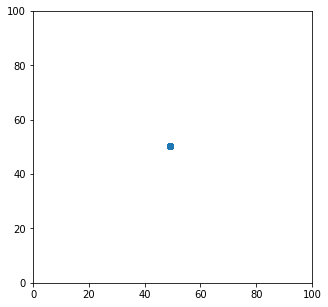

Input:  []
Preds:  [[49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49]]
Truth:  [[49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49]]


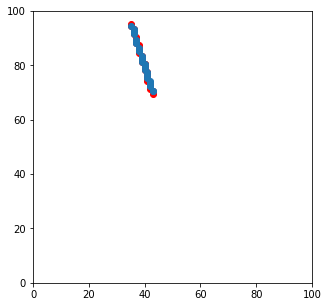

Input:  []
Preds:  [[43, 70.43], [43, 70.43], [42, 72.42], [42, 72.42], [42, 73.42], [42, 74.42], [41, 75.41], [41, 76.41], [41, 77.41], [40, 78.4], [40, 79.4], [40, 80.4], [39, 81.39], [39, 82.39], [39, 82.39], [39, 83.39], [38, 85.38], [38, 85.38], [38, 86.38], [37, 88.37], [37, 88.37], [37, 89.37], [37, 89.37], [36, 91.36], [36, 92.36], [36, 92.36], [36, 93.36], [35, 94.35]]
Truth:  [[43, 69.43], [43, 70.43], [42, 71.42], [42, 72.42], [42, 73.42], [41, 74.41], [41, 75.41], [41, 76.41], [41, 77.41], [40, 78.4], [40, 79.4], [40, 80.4], [40, 80.4], [39, 81.39], [39, 82.39], [39, 83.39], [38, 84.38], [38, 85.38], [38, 86.38], [38, 87.38], [37, 88.37], [37, 89.37], [37, 90.37], [36, 91.36], [36, 92.36], [36, 93.36], [35, 94.35], [35, 95.35]]


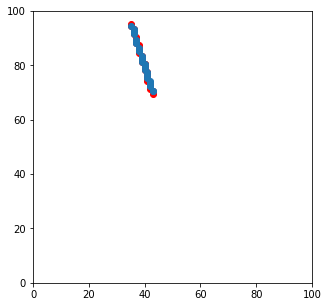

Input:  []
Preds:  [[43, 70.43], [43, 70.43], [42, 72.42], [42, 72.42], [42, 73.42], [42, 74.42], [41, 75.41], [41, 76.41], [41, 77.41], [40, 78.4], [40, 79.4], [40, 80.4], [39, 81.39], [39, 82.39], [39, 82.39], [39, 83.39], [38, 85.38], [38, 85.38], [38, 86.38], [37, 88.37], [37, 88.37], [37, 89.37], [37, 89.37], [36, 91.36], [36, 92.36], [36, 92.36], [36, 93.36], [35, 94.35]]
Truth:  [[43, 69.43], [43, 70.43], [42, 71.42], [42, 72.42], [42, 73.42], [41, 74.41], [41, 75.41], [41, 76.41], [41, 77.41], [40, 78.4], [40, 79.4], [40, 80.4], [40, 80.4], [39, 81.39], [39, 82.39], [39, 83.39], [38, 84.38], [38, 85.38], [38, 86.38], [38, 87.38], [37, 88.37], [37, 89.37], [37, 90.37], [36, 91.36], [36, 92.36], [36, 93.36], [35, 94.35], [35, 95.35]]


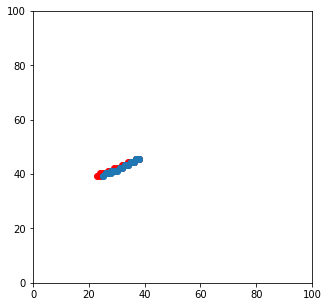

Input:  []
Preds:  [[38, 45.38], [38, 45.38], [37, 45.37], [37, 45.37], [36, 44.36], [36, 44.36], [35, 44.35], [35, 44.35], [34, 43.34], [34, 43.34], [33, 43.33], [33, 43.33], [32, 42.32], [32, 42.32], [31, 42.31], [31, 42.31], [30, 41.3], [30, 41.3], [29, 41.29], [29, 41.29], [28, 41.28], [28, 40.28], [27, 40.27], [27, 40.27], [26, 40.26], [26, 40.26], [25, 39.25], [25, 39.25]]
Truth:  [[38, 45.38], [38, 45.38], [37, 45.37], [37, 45.37], [36, 44.36], [36, 44.36], [35, 44.35], [34, 44.34], [34, 43.34], [33, 43.33], [33, 43.33], [32, 43.32], [32, 42.32], [31, 42.31], [31, 42.31], [30, 42.3], [29, 42.29], [29, 41.29], [28, 41.28], [28, 41.28], [27, 41.27], [27, 40.27], [26, 40.26], [25, 40.25], [25, 40.25], [24, 40.24], [24, 39.24], [23, 39.23]]


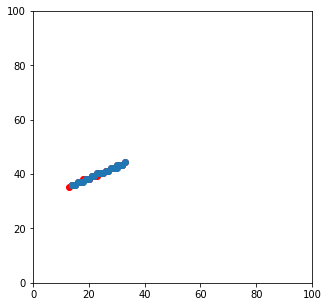

Input:  []
Preds:  [[33, 44.33], [32, 43.32], [32, 43.32], [31, 43.31], [30, 43.3], [30, 42.3], [29, 42.29], [28, 42.28], [27, 41.27], [27, 41.27], [26, 41.26], [25, 40.25], [24, 40.24], [24, 40.24], [23, 40.23], [22, 39.22], [21, 39.21], [21, 39.21], [20, 38.2], [19, 38.19], [19, 38.19], [18, 37.18], [17, 37.17], [16, 37.16], [15, 36.15], [15, 36.15], [14, 36.14], [14, 36.14]]
Truth:  [[33, 44.33], [32, 43.32], [32, 43.32], [31, 43.31], [30, 43.3], [29, 42.29], [29, 42.29], [28, 42.28], [27, 41.27], [26, 41.26], [26, 41.26], [25, 40.25], [24, 40.24], [23, 40.23], [23, 39.23], [22, 39.22], [21, 39.21], [20, 38.2], [20, 38.2], [19, 38.19], [18, 38.18], [17, 37.17], [17, 37.17], [16, 37.16], [15, 36.15], [14, 36.14], [14, 36.14], [13, 35.13]]


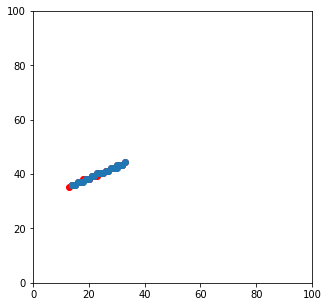

Input:  []
Preds:  [[33, 44.33], [32, 43.32], [32, 43.32], [31, 43.31], [30, 43.3], [30, 42.3], [29, 42.29], [28, 42.28], [27, 41.27], [27, 41.27], [26, 41.26], [25, 40.25], [24, 40.24], [24, 40.24], [23, 40.23], [22, 39.22], [21, 39.21], [21, 39.21], [20, 38.2], [19, 38.19], [19, 38.19], [18, 37.18], [17, 37.17], [16, 37.16], [15, 36.15], [15, 36.15], [14, 36.14], [14, 36.14]]
Truth:  [[33, 44.33], [32, 43.32], [32, 43.32], [31, 43.31], [30, 43.3], [29, 42.29], [29, 42.29], [28, 42.28], [27, 41.27], [26, 41.26], [26, 41.26], [25, 40.25], [24, 40.24], [23, 40.23], [23, 39.23], [22, 39.22], [21, 39.21], [20, 38.2], [20, 38.2], [19, 38.19], [18, 38.18], [17, 37.17], [17, 37.17], [16, 37.16], [15, 36.15], [14, 36.14], [14, 36.14], [13, 35.13]]


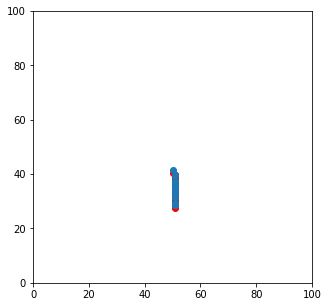

Input:  []
Preds:  [[50, 41.5], [51, 39.51], [51, 39.51], [51, 39.51], [51, 37.51], [51, 37.51], [51, 37.51], [51, 37.51], [51, 36.51], [51, 36.51], [51, 35.51], [51, 35.51], [51, 34.51], [51, 34.51], [51, 34.51], [51, 33.51], [51, 32.51], [51, 32.51], [51, 32.51], [51, 31.51], [51, 31.51], [51, 31.51], [51, 29.51], [51, 29.51], [51, 29.51], [51, 28.51], [51, 28.51], [51, 28.51]]
Truth:  [[50, 40.5], [51, 39.51], [51, 39.51], [51, 38.51], [51, 38.51], [51, 38.51], [51, 37.51], [51, 37.51], [51, 36.51], [51, 36.51], [51, 35.51], [51, 35.51], [51, 34.51], [51, 34.51], [51, 33.51], [51, 33.51], [51, 32.51], [51, 32.51], [51, 31.51], [51, 31.51], [51, 30.51], [51, 30.51], [51, 30.51], [51, 29.51], [51, 29.51], [51, 28.51], [51, 28.51], [51, 27.51]]


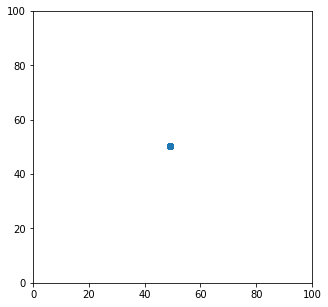

Input:  []
Preds:  [[49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49]]
Truth:  [[49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49]]


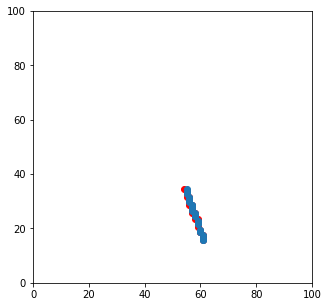

Input:  []
Preds:  [[55, 34.55], [55, 33.55], [55, 33.55], [55, 32.55], [56, 31.56], [56, 30.56], [56, 30.56], [56, 29.56], [57, 28.57], [57, 28.57], [57, 27.57], [57, 26.57], [58, 25.58], [58, 24.58], [58, 24.58], [58, 24.58], [59, 22.59], [59, 22.59], [59, 21.59], [59, 21.59], [60, 19.6], [60, 19.6], [60, 18.6], [60, 18.6], [61, 17.61], [61, 16.61], [61, 15.61], [61, 15.61]]
Truth:  [[54, 34.54], [55, 33.55], [55, 33.55], [55, 32.55], [55, 31.55], [56, 31.56], [56, 30.56], [56, 29.56], [56, 28.56], [57, 28.57], [57, 27.57], [57, 26.57], [57, 25.57], [58, 25.58], [58, 24.58], [58, 23.58], [59, 23.59], [59, 22.59], [59, 21.59], [59, 21.59], [59, 20.59], [60, 19.6], [60, 18.6], [60, 18.6], [61, 17.61], [61, 16.61], [61, 16.61], [61, 15.61]]


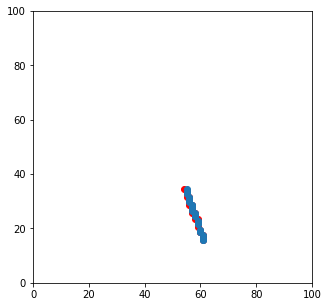

Input:  []
Preds:  [[55, 34.55], [55, 33.55], [55, 33.55], [55, 32.55], [56, 31.56], [56, 30.56], [56, 30.56], [56, 29.56], [57, 28.57], [57, 28.57], [57, 27.57], [57, 26.57], [58, 25.58], [58, 24.58], [58, 24.58], [58, 24.58], [59, 22.59], [59, 22.59], [59, 21.59], [59, 21.59], [60, 19.6], [60, 19.6], [60, 18.6], [60, 18.6], [61, 17.61], [61, 16.61], [61, 15.61], [61, 15.61]]
Truth:  [[54, 34.54], [55, 33.55], [55, 33.55], [55, 32.55], [55, 31.55], [56, 31.56], [56, 30.56], [56, 29.56], [56, 28.56], [57, 28.57], [57, 27.57], [57, 26.57], [57, 25.57], [58, 25.58], [58, 24.58], [58, 23.58], [59, 23.59], [59, 22.59], [59, 21.59], [59, 21.59], [59, 20.59], [60, 19.6], [60, 18.6], [60, 18.6], [61, 17.61], [61, 16.61], [61, 16.61], [61, 15.61]]


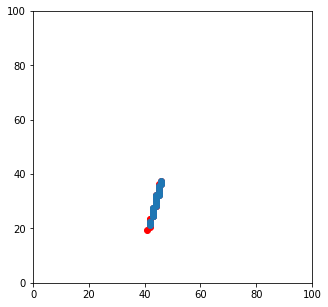

Input:  []
Preds:  [[46, 37.46], [46, 36.46], [46, 36.46], [45, 35.45], [45, 35.45], [45, 34.45], [45, 33.45], [45, 32.45], [45, 32.45], [44, 32.44], [44, 31.44], [44, 31.44], [44, 30.44], [44, 29.44], [44, 29.44], [44, 28.44], [43, 27.43], [43, 27.43], [43, 26.43], [43, 26.43], [43, 25.43], [43, 24.43], [43, 24.43], [43, 24.43], [42, 22.42], [42, 22.42], [42, 22.42], [42, 21.42]]
Truth:  [[46, 37.46], [46, 36.46], [45, 36.45], [45, 35.45], [45, 34.45], [45, 34.45], [45, 33.45], [45, 32.45], [44, 32.44], [44, 31.44], [44, 30.44], [44, 30.44], [44, 29.44], [44, 28.44], [44, 28.44], [43, 27.43], [43, 26.43], [43, 26.43], [43, 25.43], [43, 24.43], [43, 24.43], [42, 23.42], [42, 23.42], [42, 22.42], [42, 21.42], [42, 21.42], [42, 20.42], [41, 19.41]]


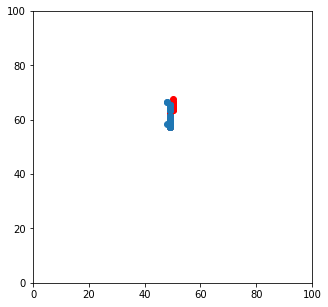

Input:  []
Preds:  [[48, 58.48], [49, 57.49], [49, 57.49], [49, 57.49], [49, 57.49], [49, 58.49], [49, 58.49], [49, 58.49], [49, 59.49], [49, 59.49], [49, 59.49], [49, 60.49], [49, 61.49], [49, 61.49], [49, 61.49], [49, 61.49], [49, 63.49], [49, 63.49], [49, 63.49], [49, 63.49], [49, 63.49], [49, 64.49], [49, 65.49], [49, 65.49], [49, 65.49], [49, 65.49], [48, 66.48], [48, 66.48]]
Truth:  [[49, 57.49], [49, 57.49], [49, 58.49], [49, 58.49], [49, 58.49], [49, 59.49], [49, 59.49], [49, 59.49], [49, 60.49], [49, 60.49], [49, 60.49], [49, 61.49], [49, 61.49], [49, 61.49], [49, 62.49], [49, 62.49], [49, 62.49], [50, 63.5], [50, 63.5], [50, 64.5], [50, 64.5], [50, 64.5], [50, 65.5], [50, 65.5], [50, 65.5], [50, 66.5], [50, 66.5], [50, 67.5]]


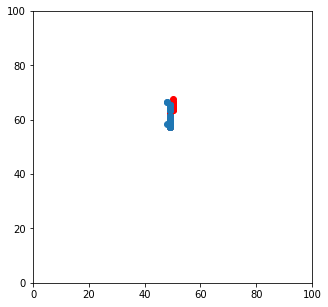

Input:  []
Preds:  [[48, 58.48], [49, 57.49], [49, 57.49], [49, 57.49], [49, 57.49], [49, 58.49], [49, 58.49], [49, 58.49], [49, 59.49], [49, 59.49], [49, 59.49], [49, 60.49], [49, 61.49], [49, 61.49], [49, 61.49], [49, 61.49], [49, 63.49], [49, 63.49], [49, 63.49], [49, 63.49], [49, 63.49], [49, 64.49], [49, 65.49], [49, 65.49], [49, 65.49], [49, 65.49], [48, 66.48], [48, 66.48]]
Truth:  [[49, 57.49], [49, 57.49], [49, 58.49], [49, 58.49], [49, 58.49], [49, 59.49], [49, 59.49], [49, 59.49], [49, 60.49], [49, 60.49], [49, 60.49], [49, 61.49], [49, 61.49], [49, 61.49], [49, 62.49], [49, 62.49], [49, 62.49], [50, 63.5], [50, 63.5], [50, 64.5], [50, 64.5], [50, 64.5], [50, 65.5], [50, 65.5], [50, 65.5], [50, 66.5], [50, 66.5], [50, 67.5]]


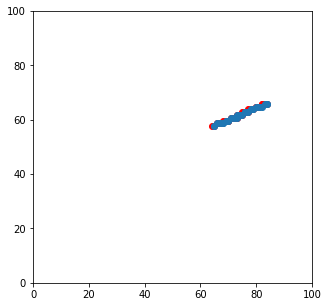

Input:  []
Preds:  [[65, 57.65], [65, 57.65], [66, 58.66], [67, 58.67], [68, 58.68], [68, 58.68], [69, 59.69], [70, 59.7], [70, 59.7], [71, 60.71], [72, 60.72], [73, 60.73], [73, 61.73], [74, 61.74], [75, 61.75], [76, 62.76], [76, 62.76], [77, 62.77], [78, 63.78], [79, 63.79], [79, 63.79], [80, 64.8], [81, 64.81], [81, 64.81], [82, 64.82], [83, 65.83], [84, 65.84], [84, 65.84]]
Truth:  [[64, 57.64], [65, 57.65], [66, 58.66], [67, 58.67], [67, 58.67], [68, 59.68], [69, 59.69], [70, 59.7], [70, 59.7], [71, 60.71], [72, 60.72], [73, 60.73], [73, 61.73], [74, 61.74], [75, 61.75], [75, 62.75], [76, 62.76], [77, 62.77], [77, 63.77], [78, 63.78], [79, 63.79], [80, 64.8], [80, 64.8], [81, 64.81], [82, 65.82], [82, 65.82], [83, 65.83], [84, 65.84]]


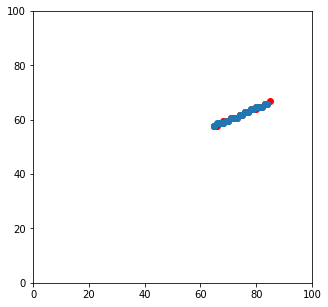

Input:  []
Preds:  [[65, 57.65], [65, 57.65], [66, 58.66], [67, 58.67], [68, 58.68], [68, 58.68], [69, 59.69], [70, 59.7], [70, 59.7], [71, 60.71], [72, 60.72], [73, 60.73], [74, 61.74], [74, 61.74], [75, 61.75], [76, 62.76], [76, 62.76], [77, 62.77], [78, 63.78], [79, 63.79], [79, 63.79], [80, 64.8], [81, 64.81], [81, 64.81], [82, 64.82], [83, 65.83], [84, 65.84], [84, 65.84]]
Truth:  [[65, 57.65], [65, 57.65], [66, 57.66], [67, 58.67], [68, 58.68], [68, 59.68], [69, 59.69], [70, 59.7], [71, 60.71], [71, 60.71], [72, 60.72], [73, 60.73], [74, 61.74], [74, 61.74], [75, 61.75], [76, 62.76], [77, 62.77], [77, 62.77], [78, 63.78], [79, 63.79], [80, 63.8], [80, 64.8], [81, 64.81], [82, 64.82], [83, 65.83], [83, 65.83], [84, 65.84], [85, 66.85]]


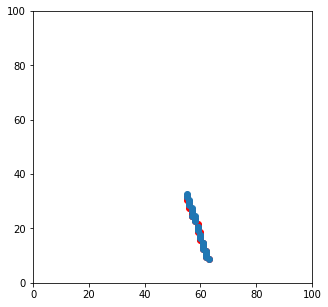

Input:  []
Preds:  [[55, 32.55], [55, 31.55], [56, 30.56], [56, 29.56], [56, 28.56], [57, 27.57], [57, 26.57], [57, 26.57], [57, 24.57], [58, 24.58], [58, 23.58], [58, 22.58], [59, 20.59], [59, 20.59], [59, 19.59], [59, 19.59], [60, 17.6], [60, 17.6], [60, 16.6], [61, 14.61], [61, 14.61], [61, 13.61], [61, 12.61], [62, 11.62], [62, 10.62], [62, 10.62], [62, 9.62], [63, 8.63]]
Truth:  [[55, 31.55], [55, 31.55], [55, 30.55], [56, 29.56], [56, 28.56], [56, 27.56], [57, 26.57], [57, 25.57], [57, 24.57], [57, 24.57], [58, 23.58], [58, 22.58], [59, 21.59], [59, 20.59], [59, 19.59], [59, 18.59], [60, 18.6], [60, 17.6], [60, 16.6], [60, 15.6], [61, 14.61], [61, 13.61], [61, 12.61], [62, 11.62], [62, 10.62], [62, 10.62], [62, 9.62], [63, 8.63]]


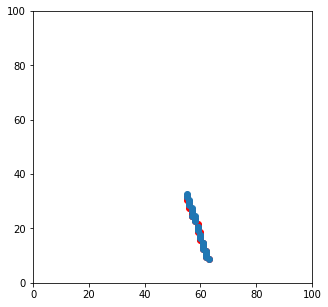

Input:  []
Preds:  [[55, 32.55], [55, 31.55], [56, 30.56], [56, 29.56], [56, 28.56], [57, 27.57], [57, 26.57], [57, 26.57], [57, 24.57], [58, 24.58], [58, 23.58], [58, 22.58], [59, 20.59], [59, 20.59], [59, 19.59], [59, 19.59], [60, 17.6], [60, 17.6], [60, 16.6], [61, 14.61], [61, 14.61], [61, 13.61], [61, 12.61], [62, 11.62], [62, 10.62], [62, 10.62], [62, 9.62], [63, 8.63]]
Truth:  [[55, 31.55], [55, 31.55], [55, 30.55], [56, 29.56], [56, 28.56], [56, 27.56], [57, 26.57], [57, 25.57], [57, 24.57], [57, 24.57], [58, 23.58], [58, 22.58], [59, 21.59], [59, 20.59], [59, 19.59], [59, 18.59], [60, 18.6], [60, 17.6], [60, 16.6], [60, 15.6], [61, 14.61], [61, 13.61], [61, 12.61], [62, 11.62], [62, 10.62], [62, 10.62], [62, 9.62], [63, 8.63]]


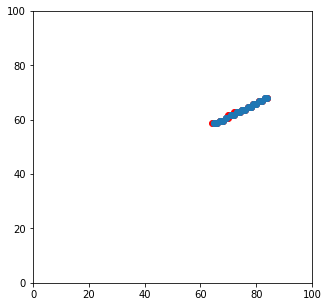

Input:  []
Preds:  [[65, 58.65], [65, 58.65], [66, 58.66], [67, 59.67], [67, 59.67], [68, 59.68], [69, 60.69], [69, 60.69], [71, 61.71], [71, 61.71], [72, 61.72], [73, 62.73], [73, 62.73], [74, 62.74], [75, 63.75], [75, 63.75], [76, 63.76], [77, 64.77], [78, 64.78], [78, 64.78], [79, 65.79], [80, 65.8], [80, 65.8], [81, 66.81], [82, 66.82], [83, 67.83], [83, 67.83], [84, 67.84]]
Truth:  [[64, 58.64], [65, 58.65], [66, 58.66], [67, 59.67], [67, 59.67], [68, 59.68], [69, 60.69], [70, 60.7], [70, 61.7], [71, 61.71], [72, 61.72], [72, 62.72], [73, 62.73], [74, 62.74], [75, 63.75], [75, 63.75], [76, 63.76], [77, 64.77], [78, 64.78], [78, 64.78], [79, 65.79], [80, 65.8], [81, 66.81], [81, 66.81], [82, 66.82], [83, 67.83], [84, 67.84], [84, 67.84]]


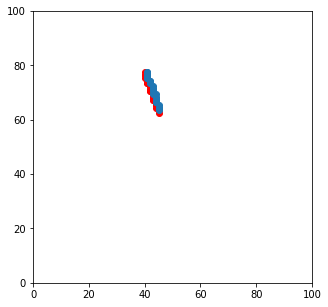

Input:  []
Preds:  [[45, 63.45], [45, 64.45], [45, 64.45], [45, 64.45], [45, 65.45], [44, 66.44], [44, 66.44], [44, 66.44], [44, 67.44], [44, 67.44], [44, 68.44], [44, 69.44], [43, 69.43], [43, 70.43], [43, 71.43], [43, 71.43], [43, 71.43], [43, 72.43], [42, 73.42], [42, 73.42], [42, 74.42], [42, 74.42], [41, 75.41], [41, 75.41], [41, 76.41], [41, 76.41], [41, 77.41], [41, 77.41]]
Truth:  [[45, 62.45], [45, 63.45], [45, 64.45], [44, 64.44], [44, 65.44], [44, 65.44], [44, 66.44], [44, 66.44], [43, 67.43], [43, 67.43], [43, 68.43], [43, 68.43], [43, 69.43], [43, 69.43], [42, 70.42], [42, 70.42], [42, 71.42], [42, 72.42], [42, 72.42], [41, 73.41], [41, 73.41], [41, 74.41], [41, 74.41], [41, 75.41], [40, 75.4], [40, 76.4], [40, 76.4], [40, 77.4]]


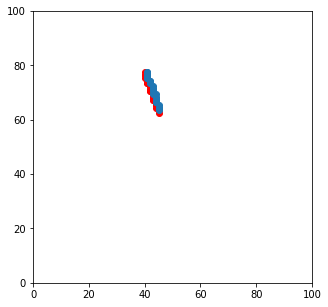

Input:  []
Preds:  [[45, 63.45], [45, 64.45], [45, 64.45], [45, 64.45], [45, 65.45], [44, 66.44], [44, 66.44], [44, 66.44], [44, 67.44], [44, 67.44], [44, 68.44], [44, 69.44], [43, 69.43], [43, 70.43], [43, 71.43], [43, 71.43], [43, 71.43], [43, 72.43], [42, 73.42], [42, 73.42], [42, 74.42], [42, 74.42], [41, 75.41], [41, 75.41], [41, 76.41], [41, 76.41], [41, 77.41], [41, 77.41]]
Truth:  [[45, 62.45], [45, 63.45], [45, 64.45], [44, 64.44], [44, 65.44], [44, 65.44], [44, 66.44], [44, 66.44], [43, 67.43], [43, 67.43], [43, 68.43], [43, 68.43], [43, 69.43], [43, 69.43], [42, 70.42], [42, 70.42], [42, 71.42], [42, 72.42], [42, 72.42], [41, 73.41], [41, 73.41], [41, 74.41], [41, 74.41], [41, 75.41], [40, 75.4], [40, 76.4], [40, 76.4], [40, 77.4]]


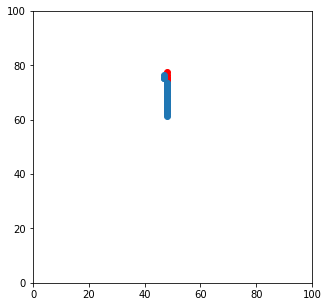

Input:  []
Preds:  [[48, 61.48], [48, 62.48], [48, 62.48], [48, 63.48], [48, 64.48], [48, 64.48], [48, 65.48], [48, 65.48], [48, 66.48], [48, 66.48], [48, 67.48], [48, 67.48], [48, 68.48], [48, 69.48], [48, 69.48], [48, 69.48], [48, 70.48], [48, 71.48], [48, 71.48], [48, 71.48], [48, 72.48], [48, 72.48], [48, 73.48], [48, 73.48], [47, 75.47], [47, 75.47], [47, 75.47], [47, 76.47]]
Truth:  [[48, 62.48], [48, 62.48], [48, 63.48], [48, 63.48], [48, 64.48], [48, 64.48], [48, 65.48], [48, 65.48], [48, 66.48], [48, 66.48], [48, 67.48], [48, 67.48], [48, 68.48], [48, 69.48], [48, 69.48], [48, 70.48], [48, 70.48], [48, 71.48], [48, 71.48], [48, 72.48], [48, 73.48], [48, 73.48], [48, 74.48], [48, 74.48], [48, 75.48], [48, 75.48], [48, 76.48], [48, 77.48]]


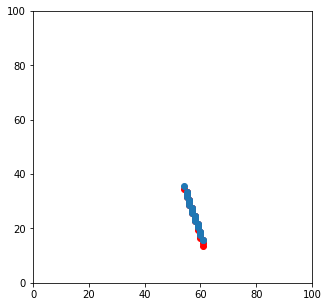

Input:  []
Preds:  [[54, 35.54], [55, 33.55], [55, 33.55], [55, 32.55], [55, 32.55], [55, 31.55], [56, 30.56], [56, 30.56], [56, 29.56], [56, 28.56], [57, 27.57], [57, 27.57], [57, 26.57], [57, 25.57], [58, 24.58], [58, 24.58], [58, 23.58], [58, 22.58], [59, 21.59], [59, 21.59], [59, 20.59], [59, 20.59], [60, 18.6], [60, 18.6], [60, 18.6], [60, 17.6], [61, 15.61], [61, 15.61]]
Truth:  [[54, 34.54], [55, 33.55], [55, 33.55], [55, 32.55], [55, 31.55], [56, 30.56], [56, 30.56], [56, 29.56], [56, 28.56], [57, 27.57], [57, 27.57], [57, 26.57], [57, 25.57], [58, 24.58], [58, 24.58], [58, 23.58], [58, 22.58], [59, 21.59], [59, 20.59], [59, 20.59], [59, 19.59], [60, 18.6], [60, 17.6], [60, 17.6], [60, 16.6], [61, 15.61], [61, 14.61], [61, 13.61]]


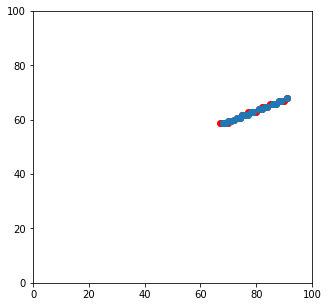

Input:  []
Preds:  [[68, 58.68], [68, 58.68], [69, 58.69], [70, 59.7], [71, 59.71], [72, 59.72], [73, 60.73], [74, 60.74], [74, 60.74], [75, 61.75], [76, 61.76], [77, 61.77], [78, 62.78], [79, 62.79], [79, 62.79], [81, 63.81], [81, 63.81], [82, 63.82], [83, 64.83], [84, 64.84], [84, 64.84], [86, 65.86], [86, 65.86], [87, 65.87], [88, 66.88], [89, 66.89], [89, 66.89], [91, 67.91]]
Truth:  [[67, 58.67], [68, 58.68], [69, 58.69], [70, 58.7], [71, 59.71], [72, 59.72], [73, 60.73], [74, 60.74], [75, 61.75], [75, 61.75], [76, 61.76], [77, 62.77], [78, 62.78], [79, 62.79], [80, 62.8], [81, 63.81], [82, 63.82], [82, 64.82], [83, 64.83], [84, 64.84], [85, 65.85], [86, 65.86], [87, 65.87], [88, 66.88], [89, 66.89], [90, 66.9], [91, 67.91], [91, 67.91]]


In [72]:
vis_trajectory_scatter(inputs_list, target_list, preds_list)

In [63]:
target_list[3]

[6943,
 7042,
 7142,
 7242,
 7341,
 7441,
 7541,
 7541,
 7640,
 7740,
 7840,
 7939,
 8039,
 8139,
 8238,
 8338,
 8438,
 8538,
 8637,
 8737,
 8837,
 8936,
 8936,
 9036,
 9135,
 9235,
 9335,
 9435]

In [ ]:
def get_coordinates():
  #input_list, target_list, preds_list = get_predictions(best_model, data_src_inputs, data_src_targets)

    min_val, max_val = 0, 100

    xy_inputs = []
    xy_preds = []
    xy_target = []

    for inp in inputs_list:
      x = inp % 100
      y = inp / 100 

      xy_inputs.append([x, y])

    for inp in preds_list:
      x = inp % 100
      y = inp / 100 
      xy_preds.append([x, y])

    for inp in target_list:
      x = inp % 100
      y = inp / 100 
      xy_target.append([x, y])

    x_inp, y_inp = zip(*xy_inputs)
    x_tar, y_tar = zip(*xy_target)
    x_pred, y_pred = zip(*xy_preds)
    
    return xy_inputs, xy_preds, xy_target

In [ ]:
xy_in, xy_preds, xy_tar = get_coordinates()

In [ ]:
output_df[['X_REAL', 'Y_REAL']] = scaler.inverse_transform(output_df[['X_REAL', 'Y_REAL']])
output_df[['X_PRED', 'Y_PRED']] = scaler.inverse_transform(output_df[['X_PRED', 'Y_PRED']])

In [ ]:
for inp in test_indx[0]:
    print(inp)